In [1]:
import time
start_time = time.time()

In [2]:
import logging
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

import arviz as az

import stan

from jax import grad, jacobian
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde as jgaussian_kde

import dask.array as da
from dask.distributed import Client, progress

import dcor

from stein_thinning.thinning import thin, thin_gf

from mcmc import sample_chain, metropolis_random_walk_step, rw_proposal_sampler
import utils.caching
from utils.caching import cached, cached_batch, subscriptable
from utils.mvn import make_mvn_mixture
from utils.parallel import apply_along_axis_parallel, get_map_parallel
from utils.plotting import highlight_points, plot_density, plot_paths, plot_sample_thinned, plot_traces
from utils.sampling import to_arviz

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
figures_path = Path('../report') / 'figures'

Directory where results of expensive calculations will be stored:

In [6]:
generated_data_dir = Path('../data') / 'generated'
utils.caching.cache_dir = generated_data_dir

In [7]:
recalculate = False  # True => perform expensive calculations, False => use stored results
save_data = recalculate

We create a Dask client in order to parallelise calculations where possible:

In [8]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40903,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:37185,Total threads: 4
Dashboard: http://127.0.0.1:44775/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:38319,


In [9]:
map_parallel = get_map_parallel(client)

# Generate synthetic data

The Lotka-Volterra model is given by the equations:
$$\begin{split}
\frac{du_1}{dt} &= \theta_1 u_1 - \theta_2 u_1 u_2, \\
\frac{du_2}{dt} &= \theta_4 u_1 u_2 - \theta_3 u_2,
\end{split}$$
where $u_1$ and $u_2$ are populations of prey and preditor, respectively, and $\theta_1, \theta_2, \theta_3, \theta_4$ are model parameters. All the quantities are positive.

Define the Lotka-Volterra model:

In [10]:
def lotka_volterra(t, u, theta):
    theta1, theta2, theta3, theta4 = theta
    u1, u2 = u
    return [
        theta1 * u1 - theta2 * u1 * u2,
        theta4 * u1 * u2 - theta3 * u2,
    ]

Solve the coupled ODEs:

In [11]:
t_n = 2400  # number of time data points
t_span = [0, 25]  # the time span over which to integrate the system
theta = [0.67, 1.33, 1., 1.]  # parameters of the model
q = 2  # number of state variables
d = len(theta)  # dimension of the parameter space
u_init = [1., 1.]  # initial values

In [12]:
def solve_lotka_volterra(theta):
    sol = solve_ivp(lotka_volterra, t_span, u_init, args=(theta,), dense_output=True)
    t = np.linspace(t_span[0], t_span[1], t_n)
    return t, sol.sol(t).T

In [13]:
t, u = solve_lotka_volterra(theta)

Add Gaussian noise:

In [14]:
rng = np.random.default_rng(12345)

In [15]:
means = [0, 0]
C = np.diag([0.2 ** 2, 0.2 ** 2])

In [16]:
eps = stats.multivariate_normal.rvs(mean=means, cov=C, size=len(u), random_state=rng)
y = u + eps

Plot the resulting values:

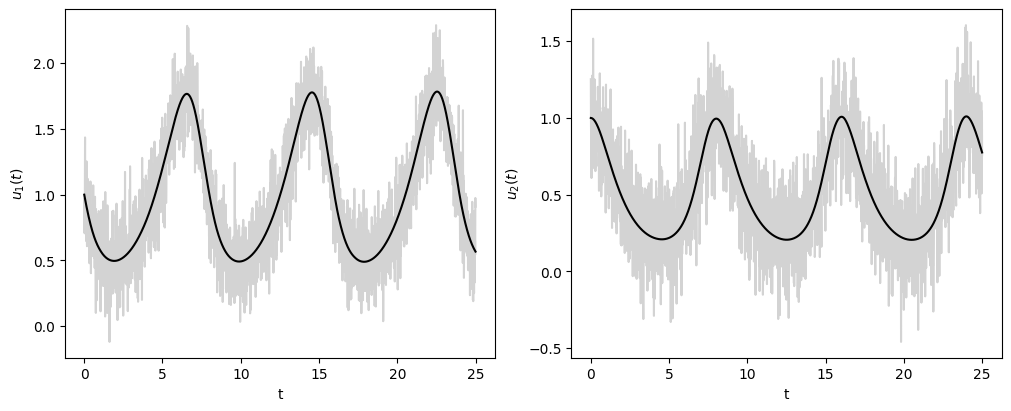

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
#fig.suptitle('Lotka-Volterra solution with added Gaussian noise');
for i in range(2):
    axs[i].plot(t, y[:, i], color='lightgray');
    axs[i].plot(t, u[:, i], color='black');
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

fig.savefig(figures_path / 'lotka-volterra.pdf');

In [18]:
if save_data:
    filepath = generated_data_dir / 'lotka_volterra_gaussian_noise.csv'
    df = pd.DataFrame({'u1': y[:, 0], 'u2': y[:, 1]}, index=pd.Index(t, name='t'))
    df.to_csv(filepath)

# Sample using a handwritten random-walk Metropolis-Hastings algorithm

Implement random-walk Metropolis-Hastings algorithm by hand:

In [19]:
def log_target_density(theta):
    _, u = solve_lotka_volterra(np.exp(theta))
    log_likelihood = np.sum(stats.multivariate_normal.logpdf(y - u, mean=means, cov=C))
    log_prior = np.sum(stats.norm.logpdf(theta))
    return log_likelihood + log_prior

In [20]:
n_samples_rw = 500_000

In [21]:
# TODO consider selecting step size automatically following Gelman, Roberts, Gilks (1996) Efficient Metropolis Jumping Rules.
step_size = 0.0025

We use the initial values from Table S3 in Supplementary Material:

In [22]:
theta_inits = [
    np.array([0.55, 1, 0.8, 0.8]),
    np.array([1.5, 1., 0.8, 0.8]),
    np.array([1.3, 1.33, 0.5, 0.8]),
    np.array([0.55, 3., 3., 0.8]),
    np.array([0.55, 1., 1.5, 1.5]),
]

In [23]:
rw_seed = 12345
def run_rw_sampler(theta_init):
    rng = np.random.default_rng(rw_seed)
    theta_sampler = metropolis_random_walk_step(log_target_density, rw_proposal_sampler(step_size, rng, d), rng)
    return sample_chain(theta_sampler, np.log(theta_init), n_samples_rw)

In [24]:
@subscriptable(n=len(theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_samples() -> list[np.ndarray]:
    return map_parallel(run_rw_sampler, theta_inits)

In [25]:
# force calculation in parallel
rw_samples[0];

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading ../data/generated/rw_samples_0.npy


Reproduce the first column in Figure S17 from the Supplementary Material:

DEBUG:utils.caching:Reading from disk cache: rw_samples_1
DEBUG:utils.caching:Reading ../data/generated/rw_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_2
DEBUG:utils.caching:Reading ../data/generated/rw_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_3
DEBUG:utils.caching:Reading ../data/generated/rw_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_4
DEBUG:utils.caching:Reading ../data/generated/rw_samples_4.npy


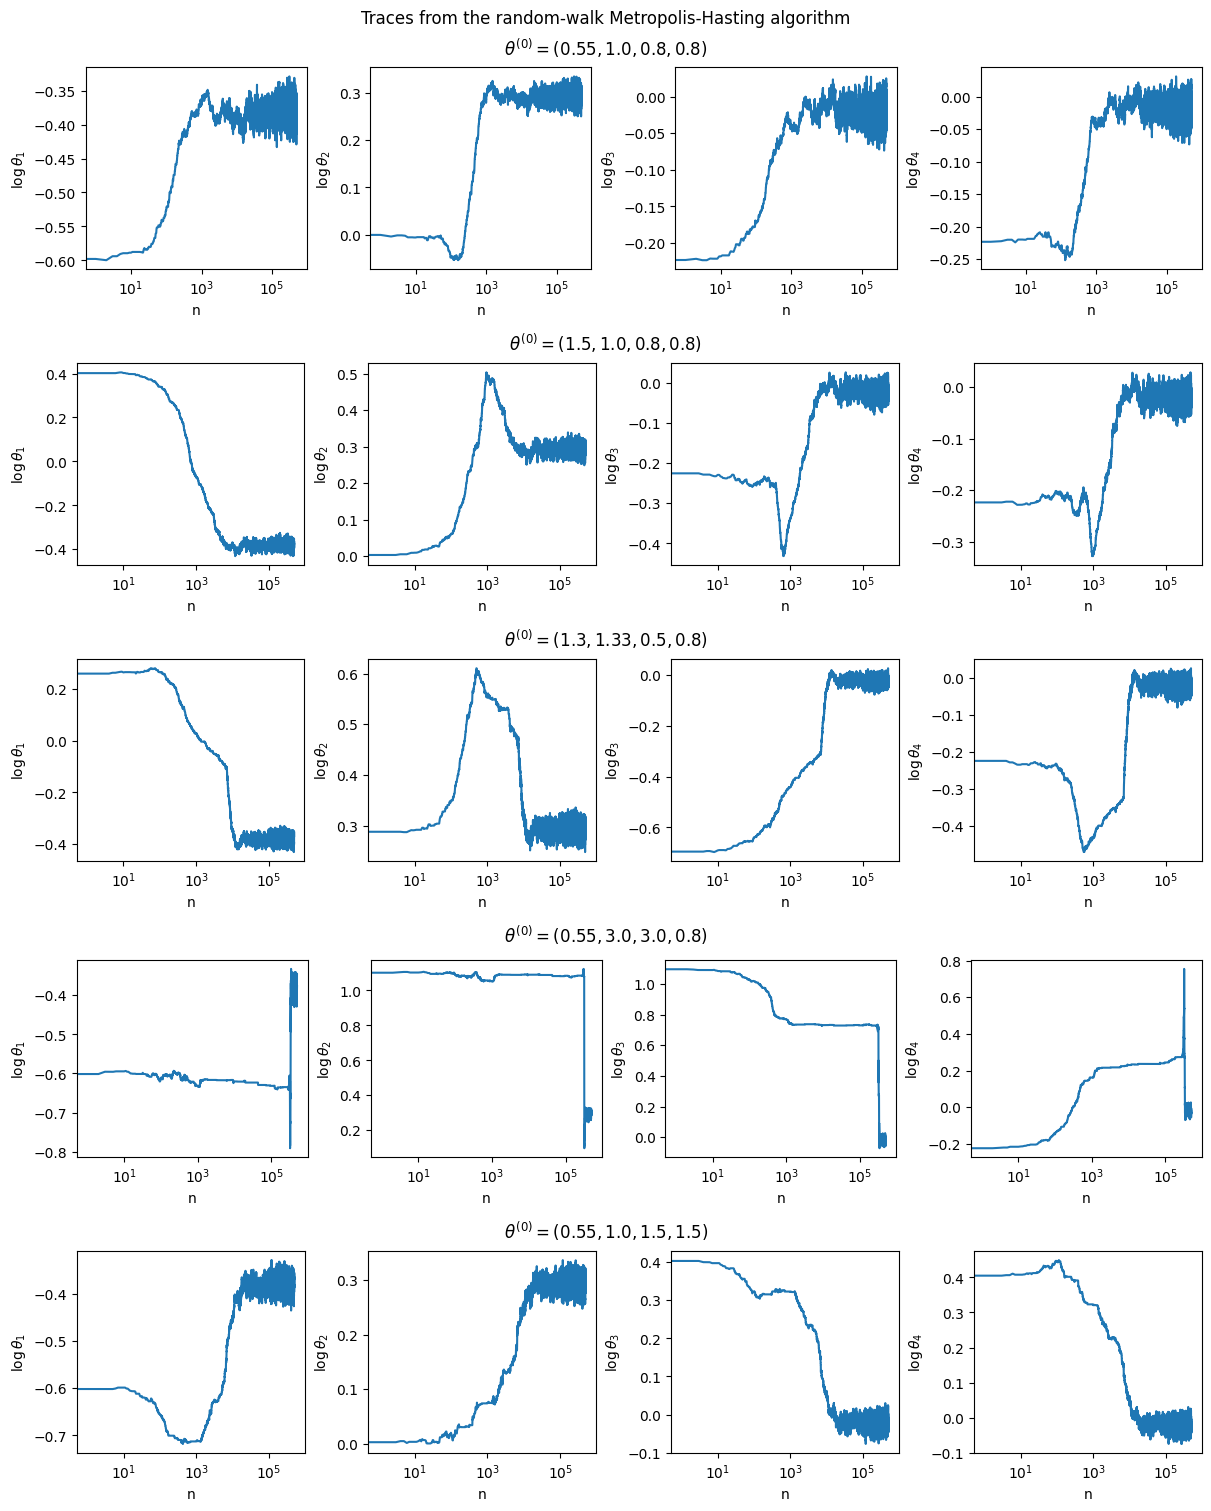

In [26]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(len(theta_inits))]
fig = plot_traces(rw_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the random-walk Metropolis-Hasting algorithm');

Produce a figure for the report:

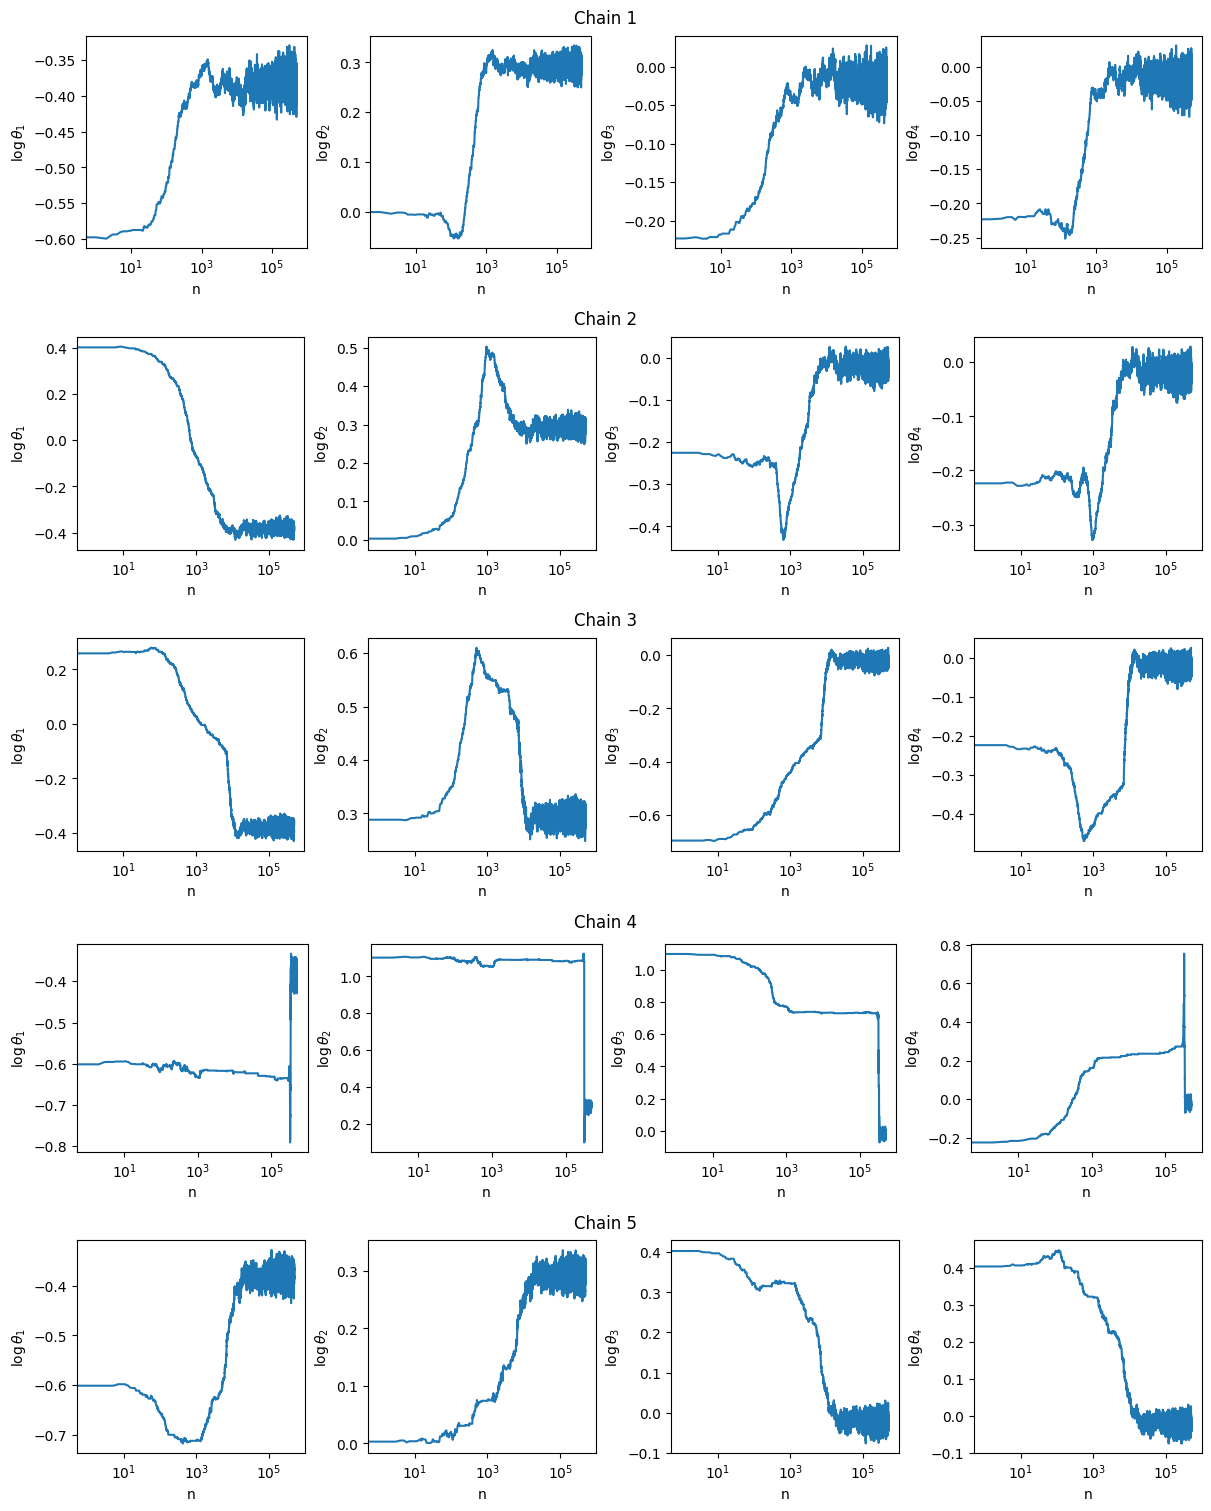

In [27]:
fig = plot_traces(rw_samples, titles=[f'Chain {i + 1}' for i in range(len(rw_samples))], var_labels=var_labels);
fig.savefig(figures_path / 'lotka-volterra-trace-plots.pdf');

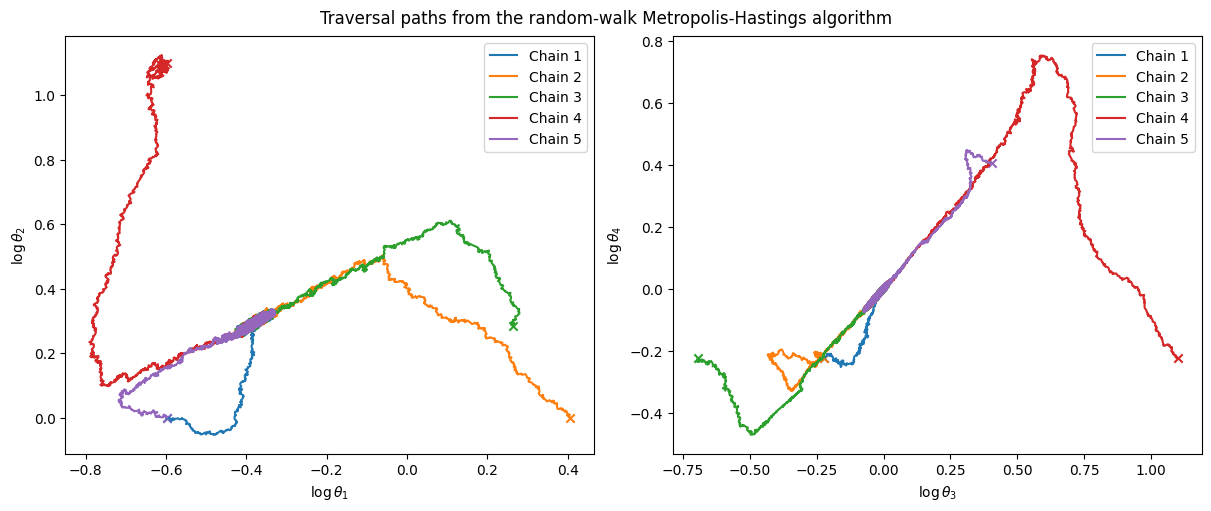

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plot_paths(rw_samples, np.log(theta_inits), idx1=0, idx2=1, ax=axs[0], label1='$\\log \\theta_1$', label2='$\\log \\theta_2$');
plot_paths(rw_samples, np.log(theta_inits), idx1=2, idx2=3, ax=axs[1], label1='$\\log \\theta_3$', label2='$\\log \\theta_4$');
fig.savefig(figures_path / 'lotka-volterra-chain-paths.png', dpi=600);
fig.suptitle('Traversal paths from the random-walk Metropolis-Hastings algorithm');

In [29]:
def acceptance_rate(sample):
    """Fraction of accepted samples"""
    return (np.sum(np.any(sample[1:] != sample[:-1], axis=1)) + 1) / sample.shape[0]

In [30]:
[acceptance_rate(sample) for sample in rw_samples]

[0.2306775386449227,
 0.23022353955292088,
 0.22811954376091248,
 0.07851784296431408,
 0.22772154455691088]

## Convergence diagnostics

``arviz`` implements $\hat{R}$ and the expected sample size as recommended in _Vehtari et al. (2021) Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC_. The paper suggests the minimum ESS of 50 for each chain and the threshold value of 1.01 for $\hat{R}$. Based on these thresholds, the chains would be deemed not to have converged:

In [31]:
@cached(recalculate=recalculate, persist=True)
def rw_az_summary() -> pd.DataFrame:
    return az.summary(to_arviz(rw_samples, var_names=[f'theta{i + 1}' for i in range(d)]))

In [32]:
rw_az_summary()

DEBUG:utils.caching:Reading from disk cache: rw_az_summary
DEBUG:utils.caching:Reading ../data/generated/rw_az_summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,-0.416,0.091,-0.636,-0.355,0.035,0.026,16.0,19.0,1.23
theta2,0.394,0.267,0.270,1.085,0.108,0.080,17.0,31.0,1.23
theta3,0.078,0.254,-0.044,0.736,0.103,0.077,14.0,13.0,1.28
theta4,0.020,0.105,-0.045,0.273,0.038,0.028,17.0,39.0,1.21


# Sample using Stan

The implementation follows https://mc-stan.org/docs/stan-users-guide/odes.html#estimating-system-parameters-and-initial-state.

In [33]:
stan_model_spec = """
functions {
  vector lotka_volterra(real t, vector u, vector theta) {
    vector[2] dudt;
    dudt[1] = exp(theta[1]) * u[1] - exp(theta[2]) * u[1] * u[2];
    dudt[2] = exp(theta[4]) * u[1] * u[2] - exp(theta[3]) * u[2];
    return dudt;
  }
}
data {
  int<lower=1> T;
  array[T] vector[2] y;
  real t0;
  array[T] real ts;
  vector[2] u0;
  vector<lower=0>[2] sigma;
}
parameters {
  vector[4] theta;
}
model {
  array[T] vector[2] u = ode_rk45(lotka_volterra, u0, t0, ts, theta);
  theta ~ std_normal();
  for (t in 1:T) {
    y[t] ~ normal(u[t], sigma);
  }
}
"""

In [34]:
data = {
    'T': t_n - 1,  # the first time is 0, for which the initial values are fixed
    'y': y[1:, :],
    't0': t_span[0],
    'ts': t[1:],
    'u0': u_init,
    'sigma': np.diag(C),  # TODO pass a matrix and use a multivariate normal in the Stan model
}

In [35]:
n_samples_hmc = 10_000

In [36]:
def extract_chains(stan_sample, param):
    """Extract chains from PyStan fit"""
    param_indices = stan_sample._parameter_indexes(param)
    return [stan_sample._draws[param_indices, :, i_chain].T for i_chain in range(stan_sample.num_chains)]

In [37]:
hmc_seed = 12345

In [38]:
@subscriptable(n=len(theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def hmc_samples() -> list[np.ndarray]:
    inference_model = stan.build(
        stan_model_spec,
        data=data,
        random_seed=hmc_seed,
    )
    stan_sample = inference_model.sample(
        num_chains=len(theta_inits),
        num_samples=n_samples_hmc,
        save_warmup=True,
        init=[{'theta': np.log(theta_init)} for theta_init in theta_inits]
    )
    return extract_chains(stan_sample, 'theta')

In [39]:
# force the calculation
hmc_samples[0];

DEBUG:utils.caching:Reading from disk cache: hmc_samples_0
DEBUG:utils.caching:Reading ../data/generated/hmc_samples_0.npy


DEBUG:utils.caching:Reading from disk cache: hmc_samples_1
DEBUG:utils.caching:Reading ../data/generated/hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_2
DEBUG:utils.caching:Reading ../data/generated/hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_3
DEBUG:utils.caching:Reading ../data/generated/hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_4
DEBUG:utils.caching:Reading ../data/generated/hmc_samples_4.npy


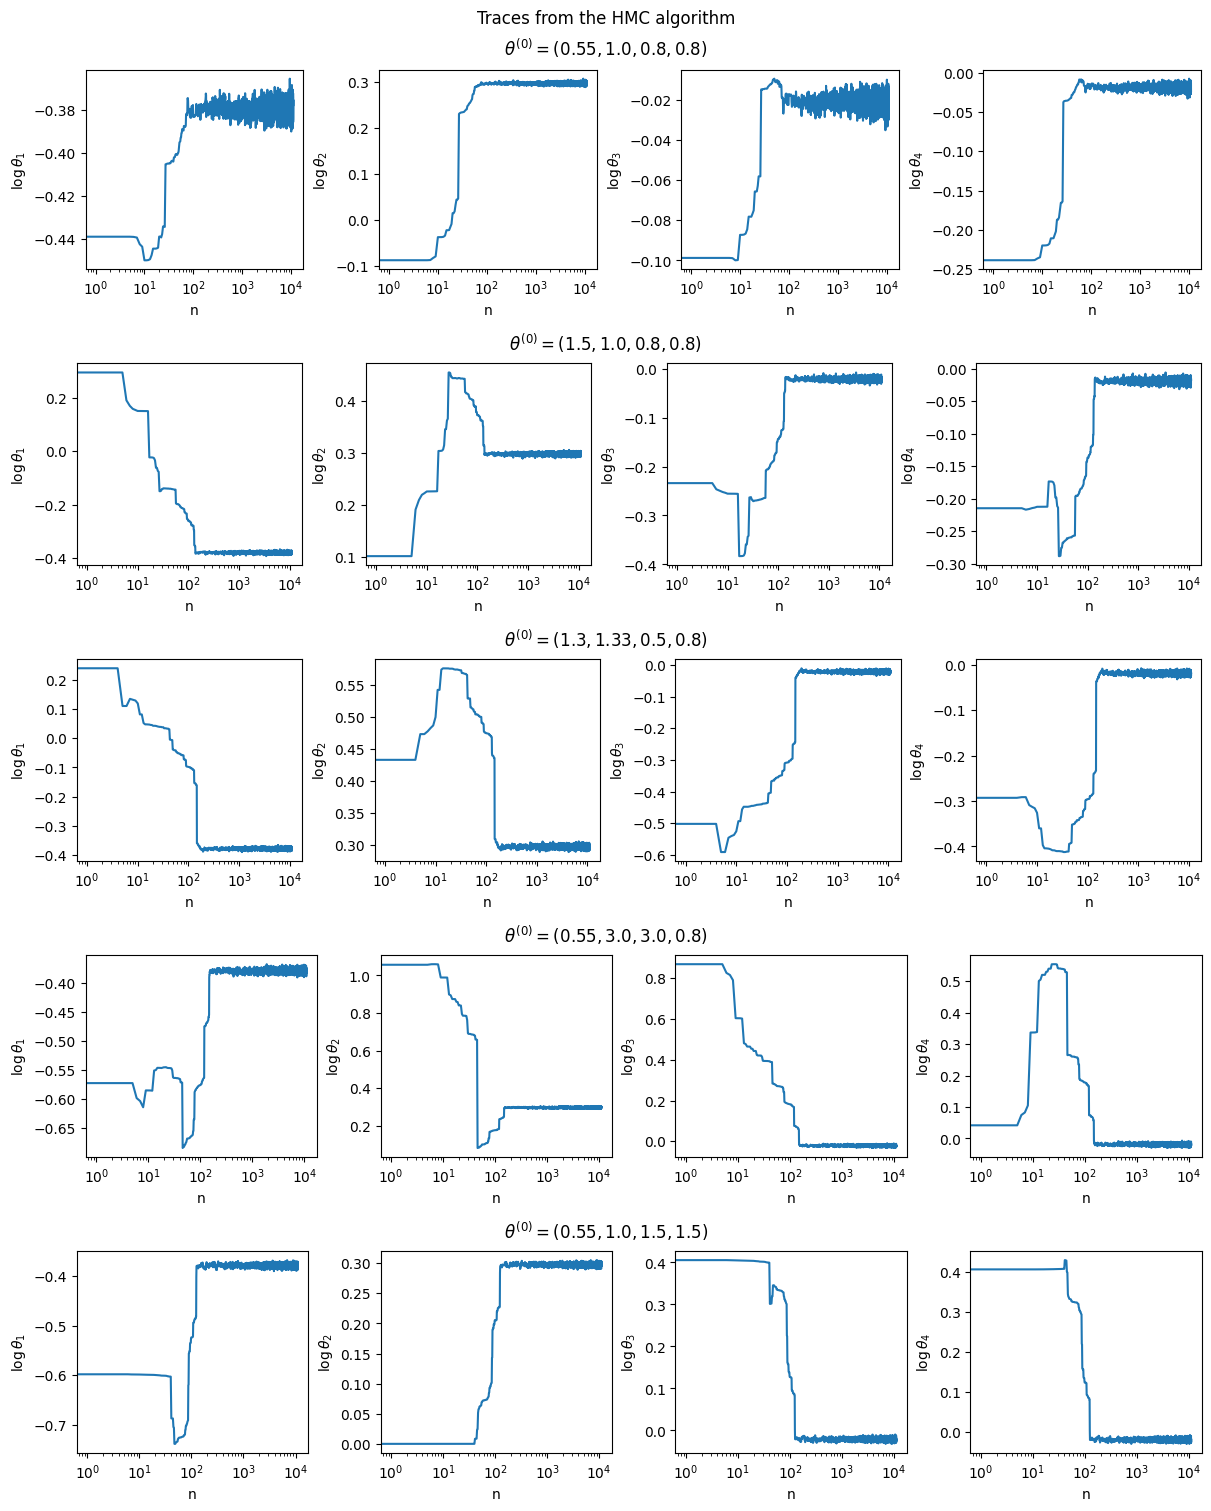

In [40]:
fig = plot_traces(hmc_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the HMC algorithm');

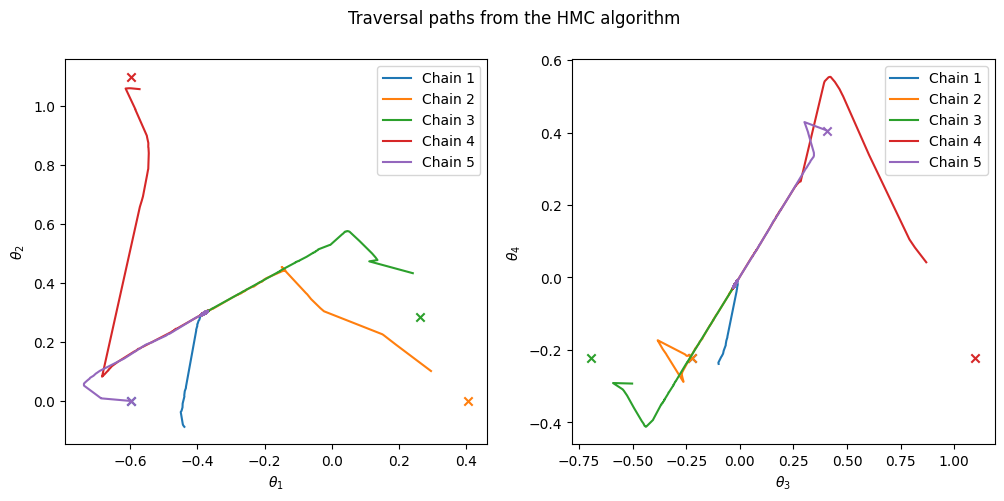

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Traversal paths from the HMC algorithm');
plot_paths(hmc_samples, np.log(theta_inits), idx1=0, idx2=1, ax=axs[0], label1='$\\theta_1$', label2='$\\theta_2$');
plot_paths(hmc_samples, np.log(theta_inits), idx1=2, idx2=3, ax=axs[1], label1='$\\theta_3$', label2='$\\theta_4$');

In [42]:
[acceptance_rate(sample) for sample in hmc_samples]

[0.9928181818181818,
 0.9916363636363636,
 0.9904545454545455,
 0.9908181818181818,
 0.990909090909091]

Based on the thresholds in _Vehtari et al. (2021) Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC_, the diagnostics do not suggest any convergence issues:

In [43]:
@cached(recalculate=recalculate, persist=True)
def hmc_az_summary() -> pd.DataFrame:
    return az.summary(to_arviz(hmc_samples, var_names=[f'theta{i + 1}' for i in range(d)]))

In [44]:
hmc_az_summary()

DEBUG:utils.caching:Reading from disk cache: hmc_az_summary
DEBUG:utils.caching:Reading ../data/generated/hmc_az_summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,-0.379,0.028,-0.386,-0.373,0.002,0.001,2992.0,2735.0,1.0
theta2,0.298,0.025,0.293,0.302,0.001,0.001,4145.0,2989.0,1.0
theta3,-0.021,0.032,-0.027,-0.015,0.002,0.002,3115.0,2727.0,1.0
theta4,-0.019,0.030,-0.025,-0.013,0.002,0.001,3090.0,2697.0,1.0


### Validation HMC sample

We generate an additional sample that we will use to evaluate the quality of fit for the proposed methods.

In [45]:
validation_hmc_seed = 98765

In [46]:
@subscriptable(n=len(theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def validation_hmc_samples() -> list[np.ndarray]:
    inference_model = stan.build(
        stan_model_spec,
        data=data,
        random_seed=validation_hmc_seed,
    )
    stan_sample = inference_model.sample(
        num_chains=len(theta_inits),
        num_samples=n_samples_hmc,
        save_warmup=False,
        init=[{'theta': np.log(theta_init)} for theta_init in theta_inits]
    )
    return extract_chains(stan_sample, 'theta')

In [47]:
# force the calculation
validation_hmc_samples[0];

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading ../data/generated/validation_hmc_samples_0.npy


DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading ../data/generated/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading ../data/generated/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading ../data/generated/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading ../data/generated/validation_hmc_samples_4.npy


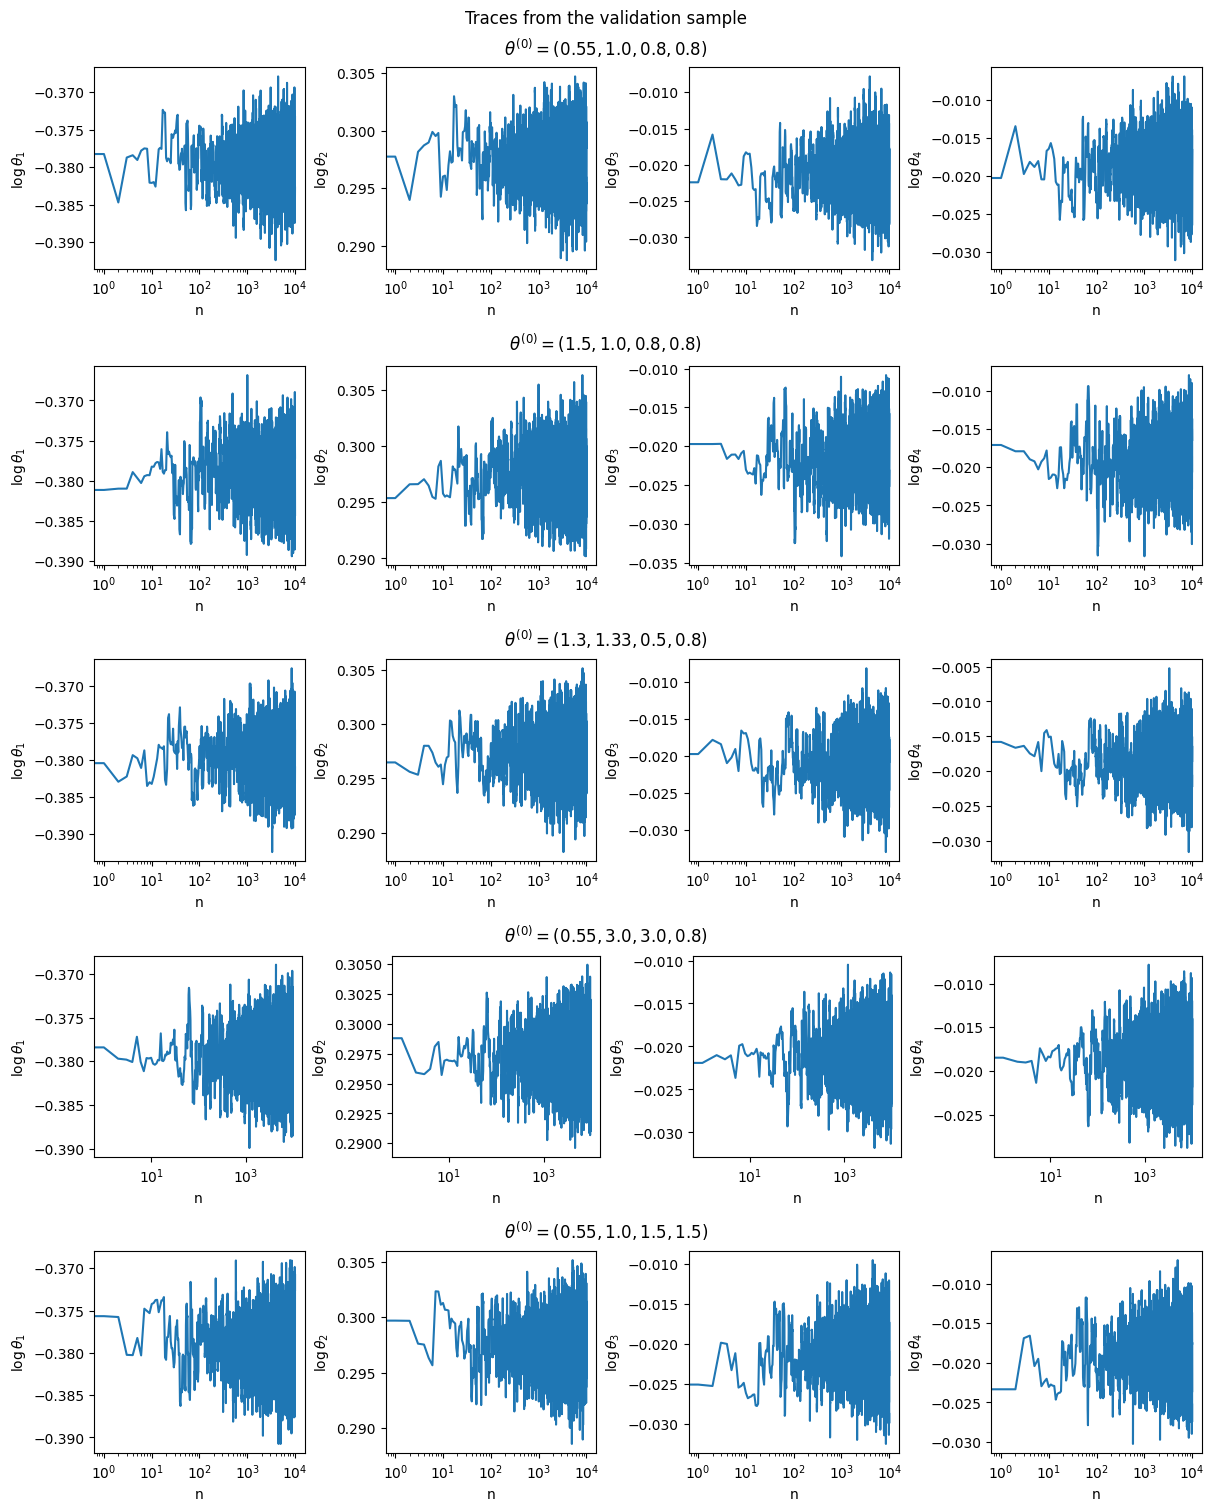

In [48]:
fig = plot_traces(validation_hmc_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the validation sample');

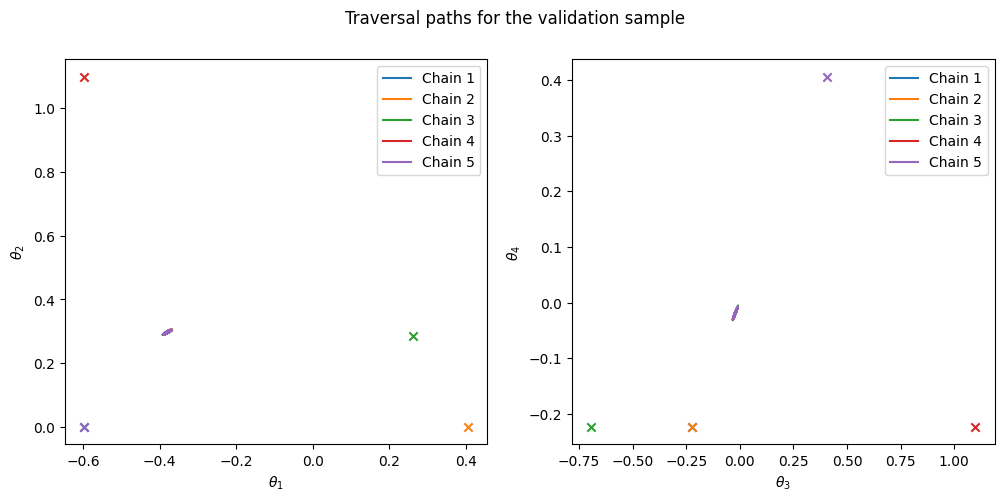

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Traversal paths for the validation sample');
plot_paths(validation_hmc_samples, np.log(theta_inits), idx1=0, idx2=1, ax=axs[0], label1='$\\theta_1$', label2='$\\theta_2$');
plot_paths(validation_hmc_samples, np.log(theta_inits), idx1=2, idx2=3, ax=axs[1], label1='$\\theta_3$', label2='$\\theta_4$');

In [50]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

# Sensitivity analysis

## Forward sensitivity equations

Given a system of ODEs of the form:
$$\frac{du_r}{dt} = F_q(t, u_1, \dots, u_q; x),\qquad r=1,\dots,q,$$
the sensitivities can be found by solving forward sensitivity equations (this is equation (35) in the Supplementary Material):
$$\frac{d}{dt}\left(\frac{\partial u_r}{\partial x_s}\right) = \frac{dF_r}{dx_s} + \sum_{l=1}^q \frac{\partial F_r}{\partial u_l} \frac{\partial u_l}{\partial x_s}$$
with initial conditions
$$\frac{\partial u_r}{\partial x_s}(0) = 0.$$

For the Lotka-Volterra model, the forward sensitivity equations are:
$$\begin{split}
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_1}\right) &= u_1 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_1} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_2}\right) &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_2} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_3}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_3} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_4}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_4} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_4}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_1}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_1} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_2}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_2} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_3}\right) &= -u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_3} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_4}\right) &= u_1 u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_4} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_4}. \\
\end{split}$$

Denoting $w_1 = \frac{\partial u_1}{\partial \theta_1}$, $w_2 = \frac{\partial u_1}{\partial \theta_2}$, $w_3 = \frac{\partial u_1}{\partial \theta_3}$, $w_4 = \frac{\partial u_1}{\partial \theta_4}$ and $w_5 = \frac{\partial u_2}{\partial \theta_1}$, $w_6 = \frac{\partial u_2}{\partial \theta_2}$, $w_7 = \frac{\partial u_2}{\partial \theta_3}$, $w_8 = \frac{\partial u_2}{\partial \theta_4}$, we have the following additional equations:
$$\begin{split}
\frac{dw_1}{dt} &= u_1 + (\theta_1 - \theta_2 u_2) w_1 - \theta_2 u_1 w_5, \\
\frac{dw_2}{dt} &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) w_2 - \theta_2 u_1 w_6, \\
\frac{dw_3}{dt} &= (\theta_1 - \theta_2 u_2) w_3 - \theta_2 u_1 w_7, \\
\frac{dw_4}{dt} &= (\theta_1 - \theta_2 u_2) w_4 - \theta_2 u_1 w_8, \\
\frac{dw_5}{dt} &= \theta_4 u_2 w_1 + (\theta_4 u_1 - \theta_3) w_5, \\
\frac{dw_6}{dt} &= \theta_4 u_2 w_2 + (\theta_4 u_1 - \theta_3) w_6, \\
\frac{dw_7}{dt} &= -u_2 + \theta_4 u_2 w_3 + (\theta_4 u_1 - \theta_3) w_7, \\
\frac{dw_8}{dt} &= u_1 u_2 + \theta_4 u_2 w_4 + (\theta_4 u_1 - \theta_3) w_8. \\
\end{split}$$

In [51]:
def lotka_volterra_sensitivity(t, uw, theta):
    theta1, theta2, theta3, theta4 = theta
    u1, u2, w1, w2, w3, w4, w5, w6, w7, w8 = uw
    return [
        # model equations
        theta1 * u1 - theta2 * u1 * u2,
        theta4 * u1 * u2 - theta3 * u2,
        # sensitivities
        u1 + (theta1 - theta2 * u2) * w1 - theta2 * u1 * w5,
        -u1 * u2 + (theta1 - theta2 * u2) * w2 - theta2 * u1 * w6,
        (theta1 - theta2 * u2) * w3 - theta2 * u1 * w7,
        (theta1 - theta2 * u2) * w4 - theta2 * u1 * w8,
        theta4 * u2 * w1 + (theta4 * u1 - theta3) * w5,
        theta4 * u2 * w2 + (theta4 * u1 - theta3) * w6,
        -u2 + theta4 * u2 * w3 + (theta4 * u1 - theta3) * w7,
        u1 * u2 + theta4 * u2 * w4 + (theta4 * u1 - theta3) * w8,
    ]

In [52]:
uw_init = np.concatenate([np.array(u_init), np.zeros(d * q)])

In [53]:
%%time
sol = solve_ivp(lotka_volterra_sensitivity, t_span, uw_init, args=(theta,), dense_output=True)
sensitivity_forward = sol.sol(t).T

CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 37.6 ms


Plot the solution again:

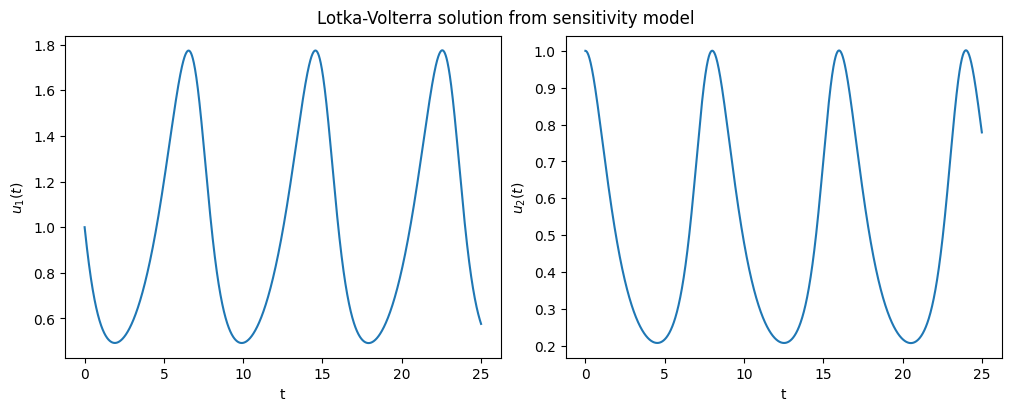

In [54]:
fig, axs = plt.subplots(1, q, figsize=(10, 4), constrained_layout=True)
fig.suptitle('Lotka-Volterra solution from sensitivity model');
for i in range(q):
    axs[i].plot(t, sensitivity_forward[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

Plot the sensitivities:

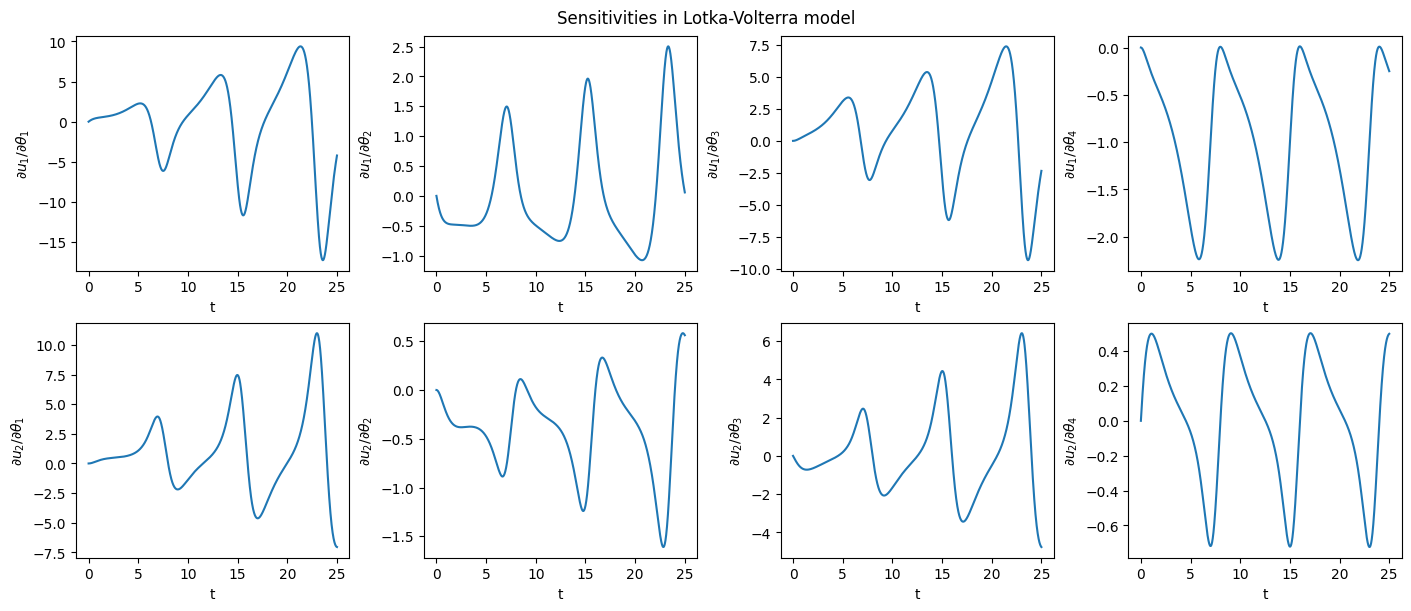

In [55]:
fig, axs = plt.subplots(q, d, figsize=(14, 6), constrained_layout=True)
fig.suptitle('Sensitivities in Lotka-Volterra model');
for i in range(q):
    for j in range(d):
        axs[i][j].plot(t, sensitivity_forward[:, q + i * d + j]);
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');

## Numerical Jacobian calculation

We need to redefine the function since ``jax.experimental.ode.odeint`` passes the state variable in the first argument and time in the second argument:

In [56]:
def lotka_volterra2(u, t, theta):
    return [
        theta[0] * u[0] - theta[1] * u[0] * u[1],
        theta[3] * u[0] * u[1] - theta[2] * u[1],
    ]

In [57]:
def solve_lotka_volterra2(theta):
    return odeint(lotka_volterra2, jnp.array(u_init), jnp.array(t), jnp.array(theta))

In [58]:
sol2 = solve_lotka_volterra2(theta)

Plot the solution first:

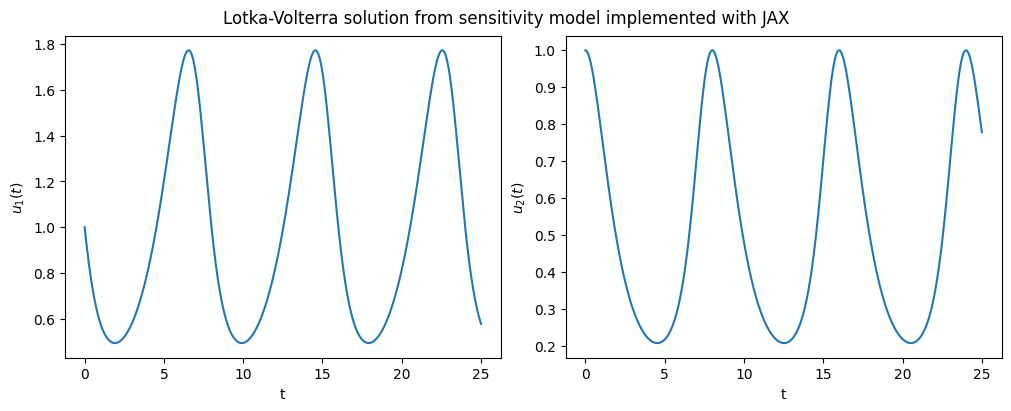

In [59]:
fig, axs = plt.subplots(1, q, figsize=(10, 4), constrained_layout=True)
fig.suptitle('Lotka-Volterra solution from sensitivity model implemented with JAX');
for i in range(q):
    axs[i].plot(t, sol2[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

Calculate the sensitivities:

In [60]:
@cached(recalculate=recalculate, persist=True)
def sensitivity_jax() -> np.ndarray:
    return np.stack(jacobian(solve_lotka_volterra2)(theta))

We confirm that the numerical method agrees with the results from forward sensitivity equations:

DEBUG:utils.caching:Reading from disk cache: sensitivity_jax
DEBUG:utils.caching:Reading ../data/generated/sensitivity_jax.npy


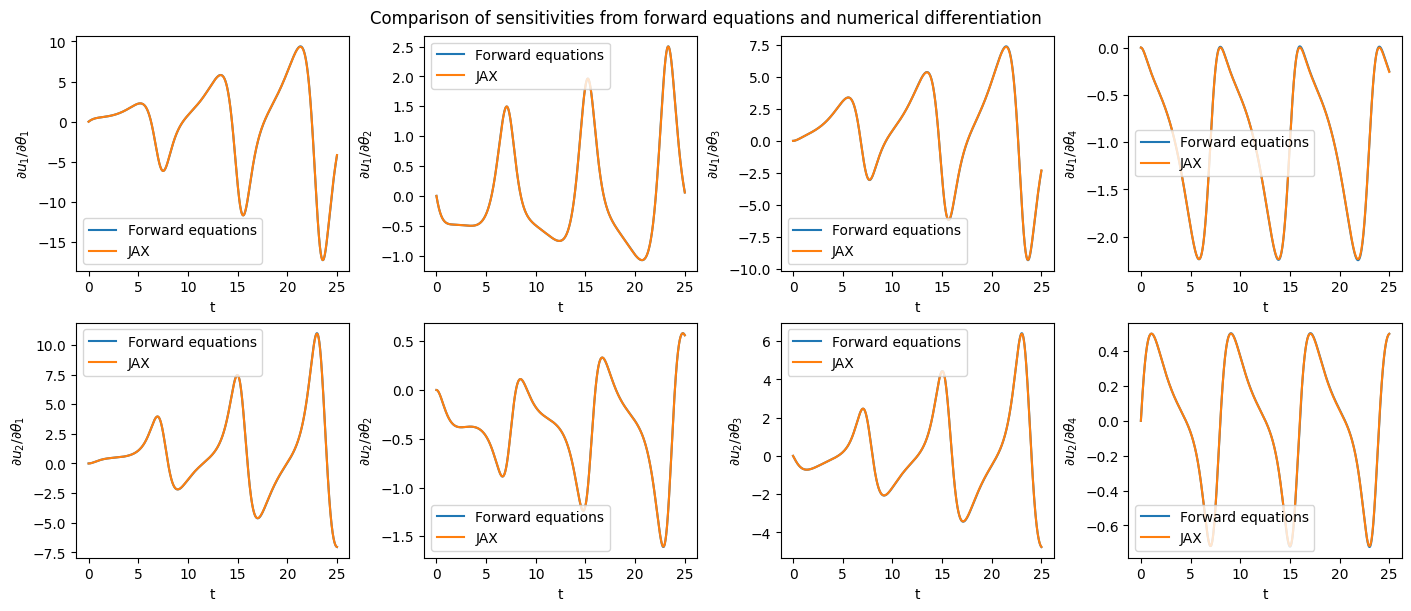

In [61]:
fig, axs = plt.subplots(q, d, figsize=(14, 6), constrained_layout=True)
fig.suptitle('Comparison of sensitivities from forward equations and numerical differentiation');
for i in range(2):
    for j in range(d):
        axs[i][j].plot(t, sensitivity_forward[:, 2 + i * d + j], label='Forward equations');
        axs[i][j].plot(t, sensitivity_jax()[j, :, i], label='JAX');
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');
        axs[i][j].legend();

## Calculating the gradient of the log-posterior

The Stein Thinning methog requires the gradient of the log-posterior $\nabla \log p$ as input. Below we follow section S3 of the Supplementary Material to derive it.

Since $p(x) \propto \mathcal{L}(x) \pi(x)$, we have 
$$\nabla_x \log p(x) = \nabla_x \log \mathcal{L}(x) + \nabla_x \log \pi(x).$$
Assuming independent errors in observations yields
$$\mathcal{L}(x) = \prod_{i=1}^N \phi_i(u(t_i)),$$
and thus 
$$
\frac{\partial}{\partial x_s} \log \mathcal{L}(x) 
= \sum_{i=1}^N \frac{\partial}{\partial x_s} \log \phi_i(u(t_i))
= \sum_{i=1}^N \sum_{r=1}^q \frac{\partial}{\partial u_r} (\log \phi_i) \frac{\partial u_r}{\partial x_s},
$$
which can be written in matrix notation as
$$(\nabla_x \log \mathcal{L})(x) = \sum_{i=1}^N \left(\frac{\partial u}{\partial x}\right)^T\! (t_i)\, (\nabla_u \log \phi_i)(u(t_i)),$$
where
$$\left(\frac{\partial u}{\partial x}\right)_{r,s} = \frac{\partial u_r}{\partial x_s}$$
is the Jacobian matrix of sensitivities, as obtained earlier.

Note that this does not match the expression provided on page 16 of the Supplementary Material:
$$(\nabla \log \mathcal{L})(x) = -\sum_{i=1}^N \frac{\partial u}{\partial x}(t_i) (\nabla \log \phi_i)(u(t_i)),$$
where the Jacobian is not transposed and there is a minus sign in front of the expression.

For a multivariate normal distribution of the errors:
$$\phi_i(u(t_i)) \propto \exp\left( -\frac{1}{2} (y_i - u(t_i))^T C^{-1} (y_i - u(t_i)) \right)$$
we obtain
$$(\nabla_u \log \phi_i)(u(t_i)) = C^{-1}(y_i - u(t_i)).$$

We assume independent standard normal priors for all parameters, therefore
$$\pi(x) = \prod_{i=1}^d \pi_i(x_i) \propto \exp\left(-\frac{1}{2}\sum_{i=1}^d x_i^2\right)$$
and
$$\nabla_x \log \pi(x) = -x.$$

We calculate the gradient of the log-likelihood from the Jacobian obtained previosly:

In [62]:
# reshape the Jacobian so it can be multiplied by the gradient of log phi
J = sensitivity_forward[:, q:].reshape(len(t), -1, q, order='F')
J.shape

(2400, 4, 2)

In [63]:
# calculate the gradient of log phi and reshape it
grad_log_phi = (inv(C) @ (y - sensitivity_forward[:, :q]).T).T[:, :, np.newaxis]
grad_log_phi.shape

(2400, 2, 1)

In [64]:
grad_log_lik = np.sum(np.squeeze(J @ grad_log_phi), axis=0)
grad_log_lik

array([ 909.8283571 , -161.34819546,  313.24871815,   71.0105305 ])

Now put the calculation into a function so we can use it later:

In [65]:
def grad_log_likelihood(theta):
    """Solve the system of ODEs and calculate the log-likelihood"""
    sol = solve_ivp(lotka_volterra_sensitivity, t_span, uw_init, args=(theta,), dense_output=True)
    sensitivity_forward = sol.sol(t).T
    J = sensitivity_forward[:, q:].reshape(len(t), -1, q, order='F')
    grad_log_phi = (inv(C) @ (y - sensitivity_forward[:, :q]).T).T[:, :, np.newaxis]
    return np.sum(np.squeeze(J @ grad_log_phi), axis=0)

In [66]:
%%time
grad_log_likelihood(theta)

CPU times: user 16.8 ms, sys: 69 μs, total: 16.8 ms
Wall time: 22.4 ms


array([ 909.8283571 , -161.34819546,  313.24871815,   71.0105305 ])

We check the numbers against the numerical gradient:

In [67]:
def grad_log_likelihood_jax(theta):
    import jax.scipy.stats as jstats
    def log_likelihood(theta):
        sol = odeint(lotka_volterra2, jnp.array(u_init), jnp.array(t), jnp.array(theta))
        return jnp.sum(jstats.multivariate_normal.logpdf(jnp.array(y) - sol, mean=jnp.array(means), cov=jnp.array(C)))
    return jacobian(log_likelihood)(theta)

In [68]:
%%time
grad_log_likelihood_jax(theta)

CPU times: user 3.45 s, sys: 221 ms, total: 3.67 s
Wall time: 7.95 s


[Array(872.54626, dtype=float32, weak_type=True),
 Array(-144.05716, dtype=float32, weak_type=True),
 Array(307.38287, dtype=float32, weak_type=True),
 Array(64.167496, dtype=float32, weak_type=True)]

We use the gradient calculation based on solving forward sensitivity equations in what follows.

In [69]:
def grad_log_posterior(theta):
    return grad_log_likelihood(theta) - theta

In [70]:
grad_log_posterior(theta)

array([ 909.1583571 , -162.67819546,  312.24871815,   70.0105305 ])

## Parallel calculation of gradients

We note that calculating gradients after a MCMC run is what is called "embarrassingly parallelisable" and the time required for this step can be effectively eliminated given sufficient computational resources. This is in contrast to the MCMC run itself, which is inherently sequential.

Here we demonstrate how the popular package ``Dask`` can be used to parallelise this computation across cores of a local machine.

See the notebook in ``examples/Dask_AWS.ipynb`` for a comparison between sequential calculation, parallel computation locally and on AWS.

We can save time by calculating the gradients for unique samples only:

A helper function to calculate gradients using unique values only:

In [71]:
def parallelise_for_unique(func, sample, row_chunk_size=200):
    """Calculate gradients for samples"""
    # we can save time by calculating gradients for unique samples only
    unique_samples, inverse_index = np.unique(sample, axis=0, return_inverse=True)
    res = apply_along_axis_parallel(func, 1, unique_samples, row_chunk_size, client)
    return res[inverse_index]

Calculate the gradients for the random-walk samples:

In [72]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_grads(i: int) -> np.ndarray:
    return parallelise_for_unique(grad_log_posterior, np.exp(rw_samples[i]))

Calculate the gradients for HMC samples:

In [73]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def hmc_grads(i: int) -> np.ndarray:
    return parallelise_for_unique(grad_log_posterior, np.exp(hmc_samples[i]))

# Apply Stein thinning

### Random-walk sample

In [74]:
n_points_thinned = 20

In [75]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_thinned_idx(i: int) -> np.ndarray:
    return thin(np.exp(rw_samples[i]), rw_grads[i], n_points_thinned, preconditioner='med')

This reproduces the results shown in Figure S20 in the Supplementary Material:

DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_0
DEBUG:utils.caching:Reading ../data/generated/rw_thinned_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_1
DEBUG:utils.caching:Reading ../data/generated/rw_thinned_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_2
DEBUG:utils.caching:Reading ../data/generated/rw_thinned_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_3
DEBUG:utils.caching:Reading ../data/generated/rw_thinned_idx_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_4
DEBUG:utils.caching:Reading ../data/generated/rw_thinned_idx_4.npy


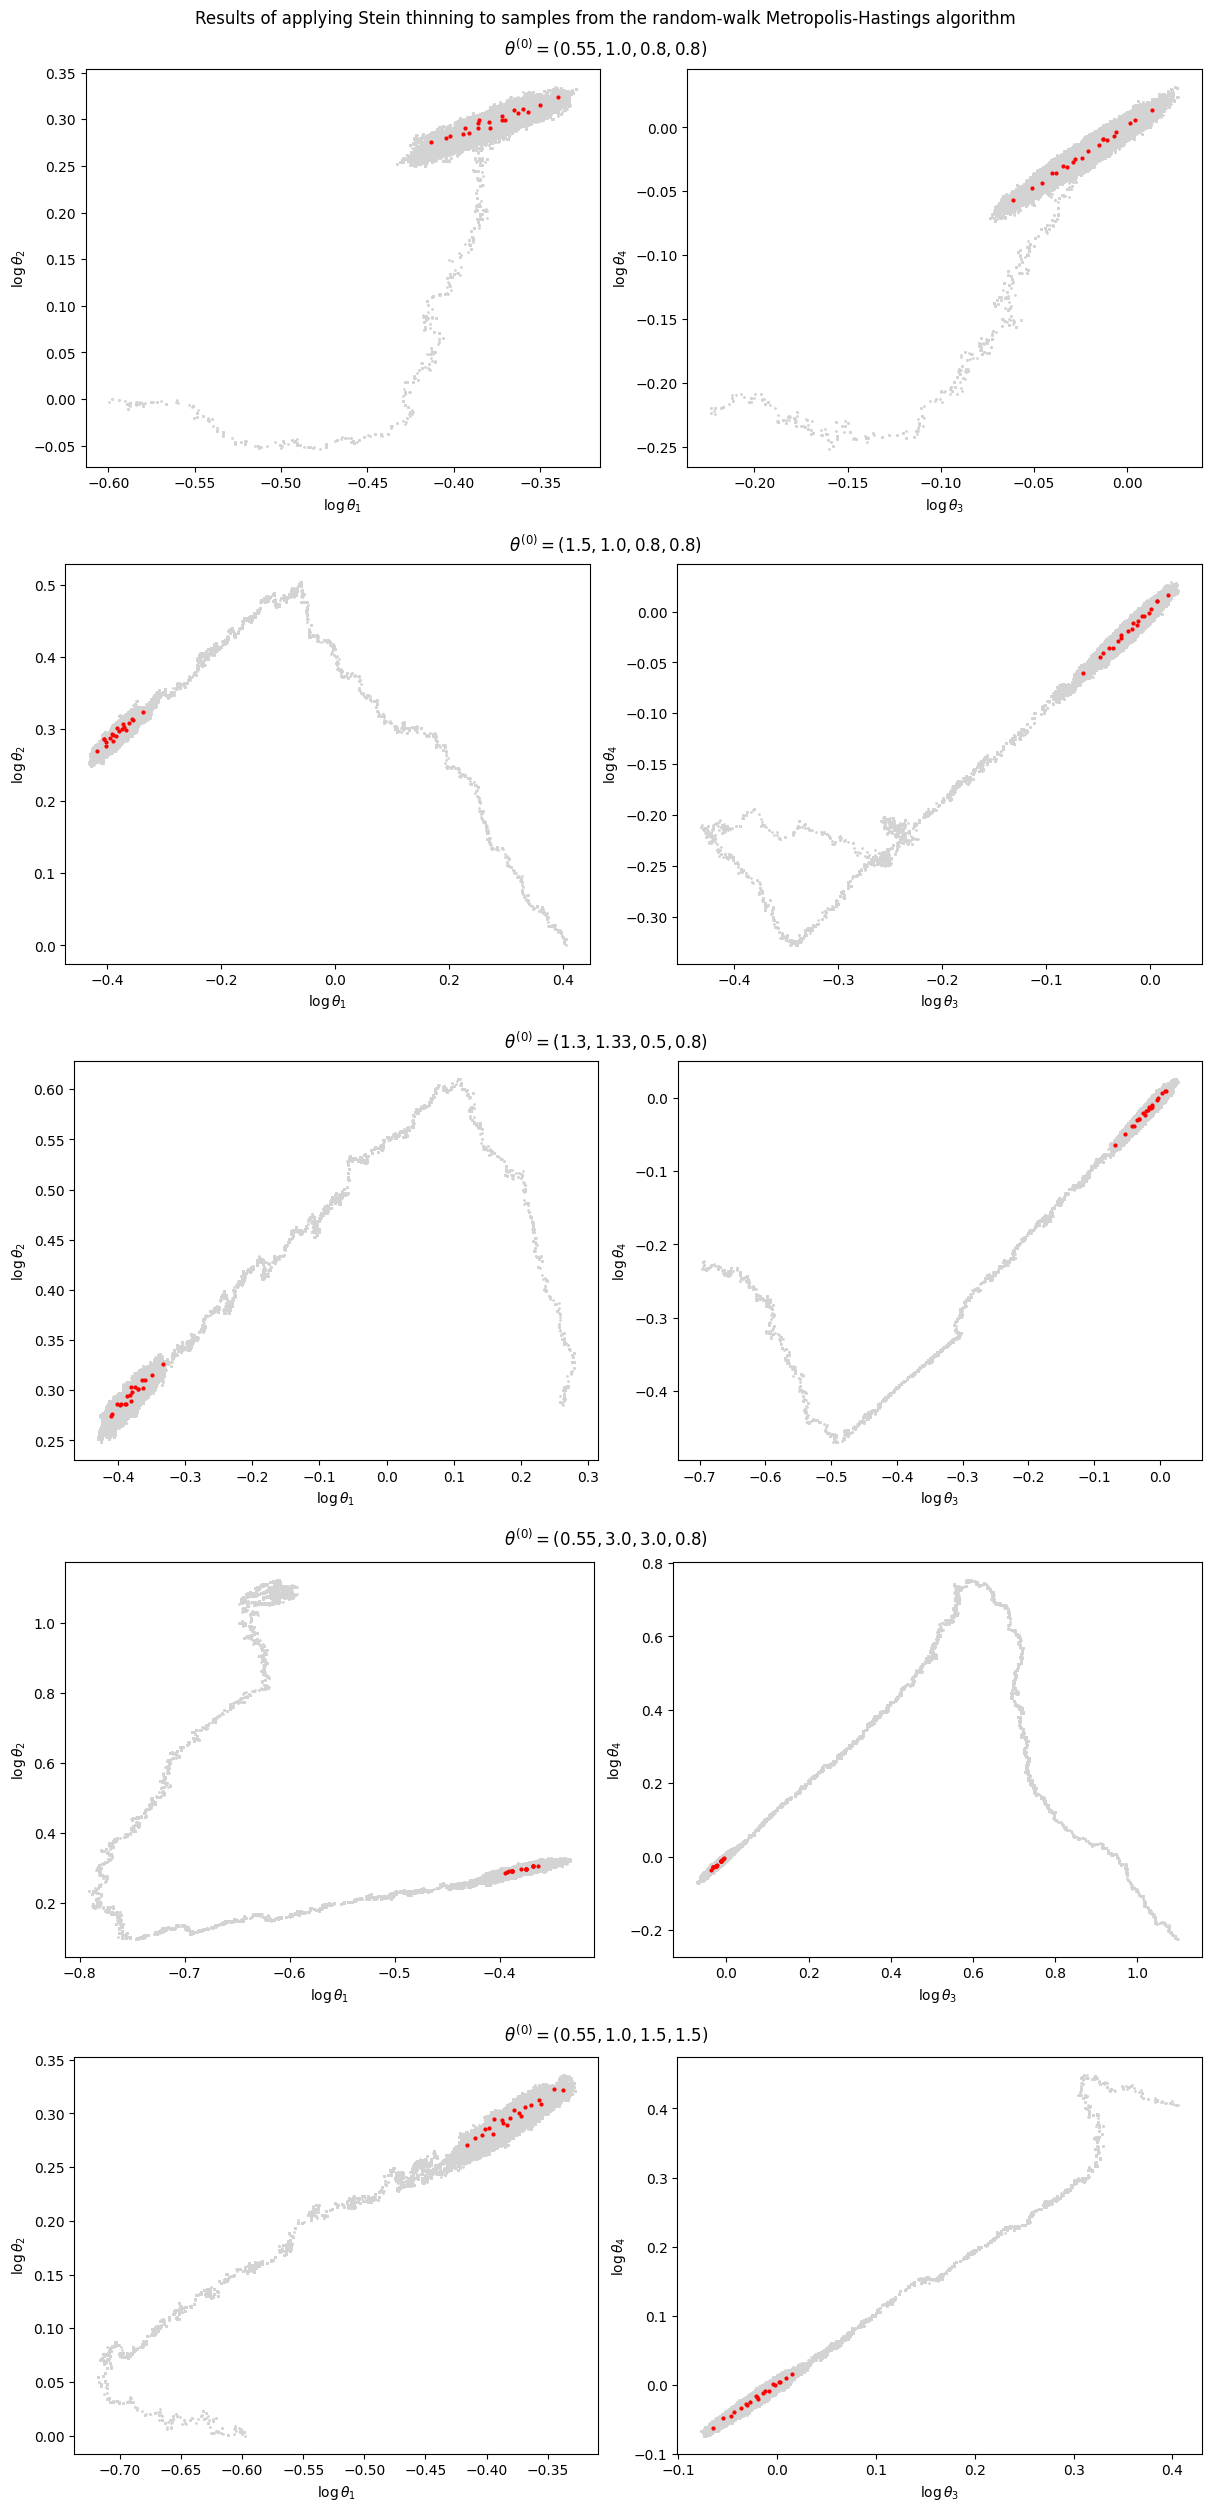

In [76]:
fig = plot_sample_thinned(rw_samples, rw_thinned_idx, titles, var_labels);
fig.savefig(figures_path / 'lotka-volterra-stein-thinning.png', dpi=300);
fig.suptitle('Results of applying Stein thinning to samples from the random-walk Metropolis-Hastings algorithm');

### HMC sample

In [77]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def hmc_thinned_idx(i: int) -> np.ndarray:
    return thin(np.exp(hmc_samples[i]), hmc_grads[i], n_points_thinned, preconditioner='med')

DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_0
DEBUG:utils.caching:Reading ../data/generated/hmc_thinned_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_1
DEBUG:utils.caching:Reading ../data/generated/hmc_thinned_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_2
DEBUG:utils.caching:Reading ../data/generated/hmc_thinned_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_3
DEBUG:utils.caching:Reading ../data/generated/hmc_thinned_idx_3.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_4
DEBUG:utils.caching:Reading ../data/generated/hmc_thinned_idx_4.npy


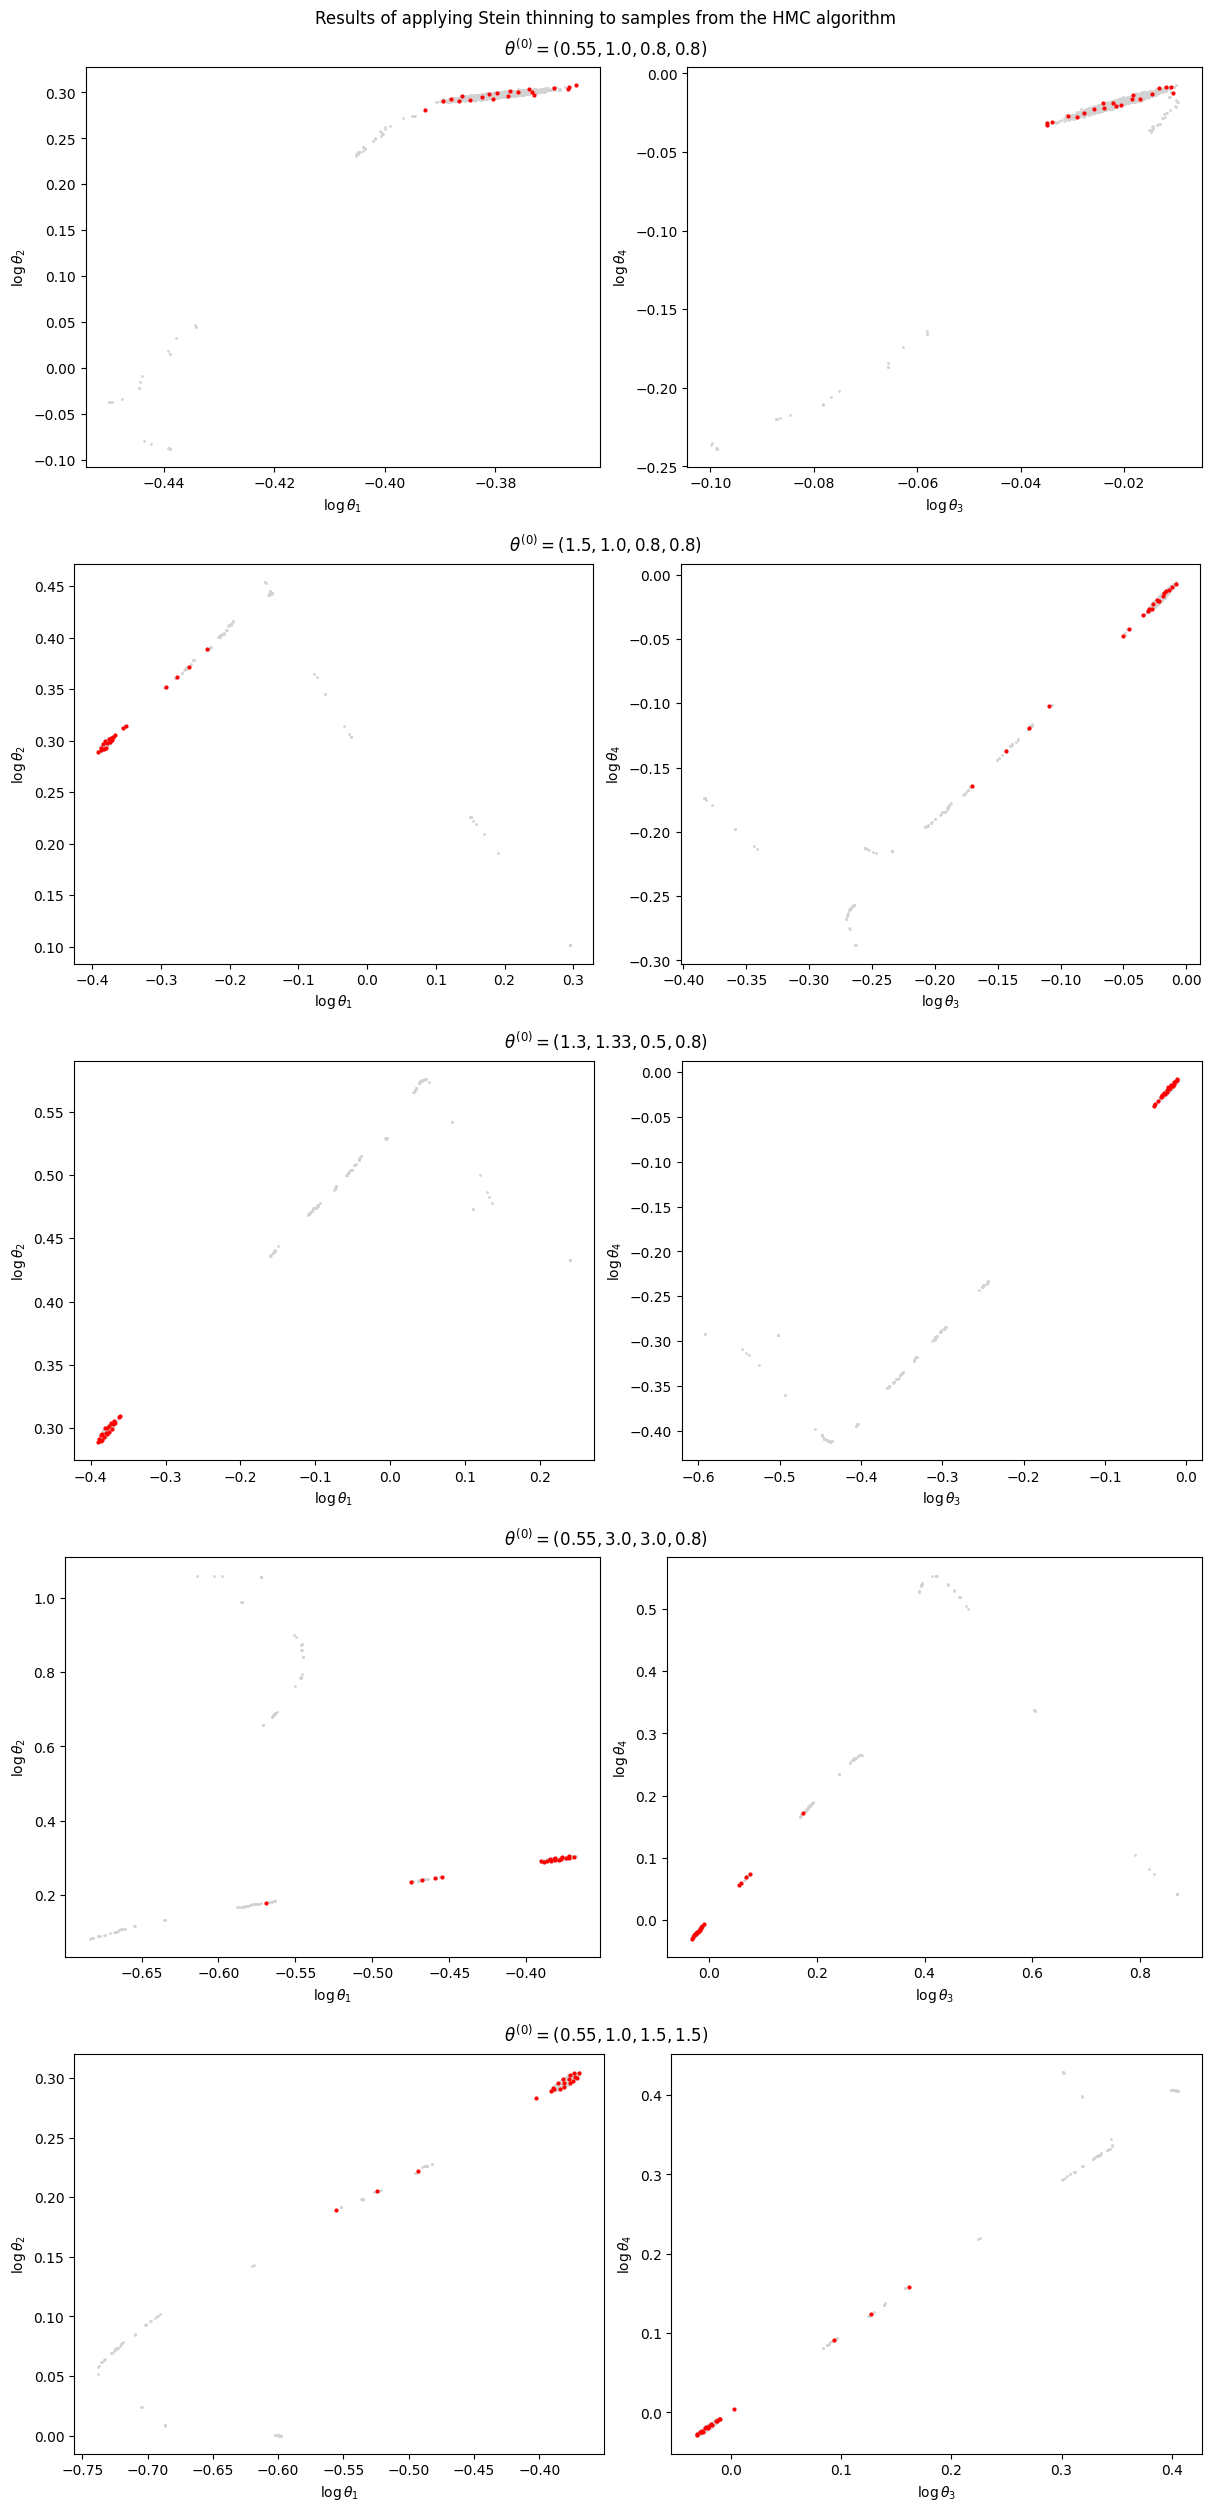

In [78]:
fig = plot_sample_thinned(hmc_samples, hmc_thinned_idx, titles, var_labels);
fig.suptitle('Results of applying Stein thinning to samples from the HMC algorithm');

# Naive thinning

The baseline for comparison is the naive thinning approach where we retain each $i$-th element of the sample.

In [79]:
def naive_thin(sample_size, thinned_size):
    return np.linspace(0, sample_size - 1, thinned_size).astype(int)

In [80]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_naive_idx(i: int) -> np.ndarray:
    return naive_thin(rw_samples[i].shape[0], n_points_thinned)

DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_0
DEBUG:utils.caching:Reading ../data/generated/rw_naive_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_1
DEBUG:utils.caching:Reading ../data/generated/rw_naive_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_2
DEBUG:utils.caching:Reading ../data/generated/rw_naive_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_3
DEBUG:utils.caching:Reading ../data/generated/rw_naive_idx_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_4
DEBUG:utils.caching:Reading ../data/generated/rw_naive_idx_4.npy


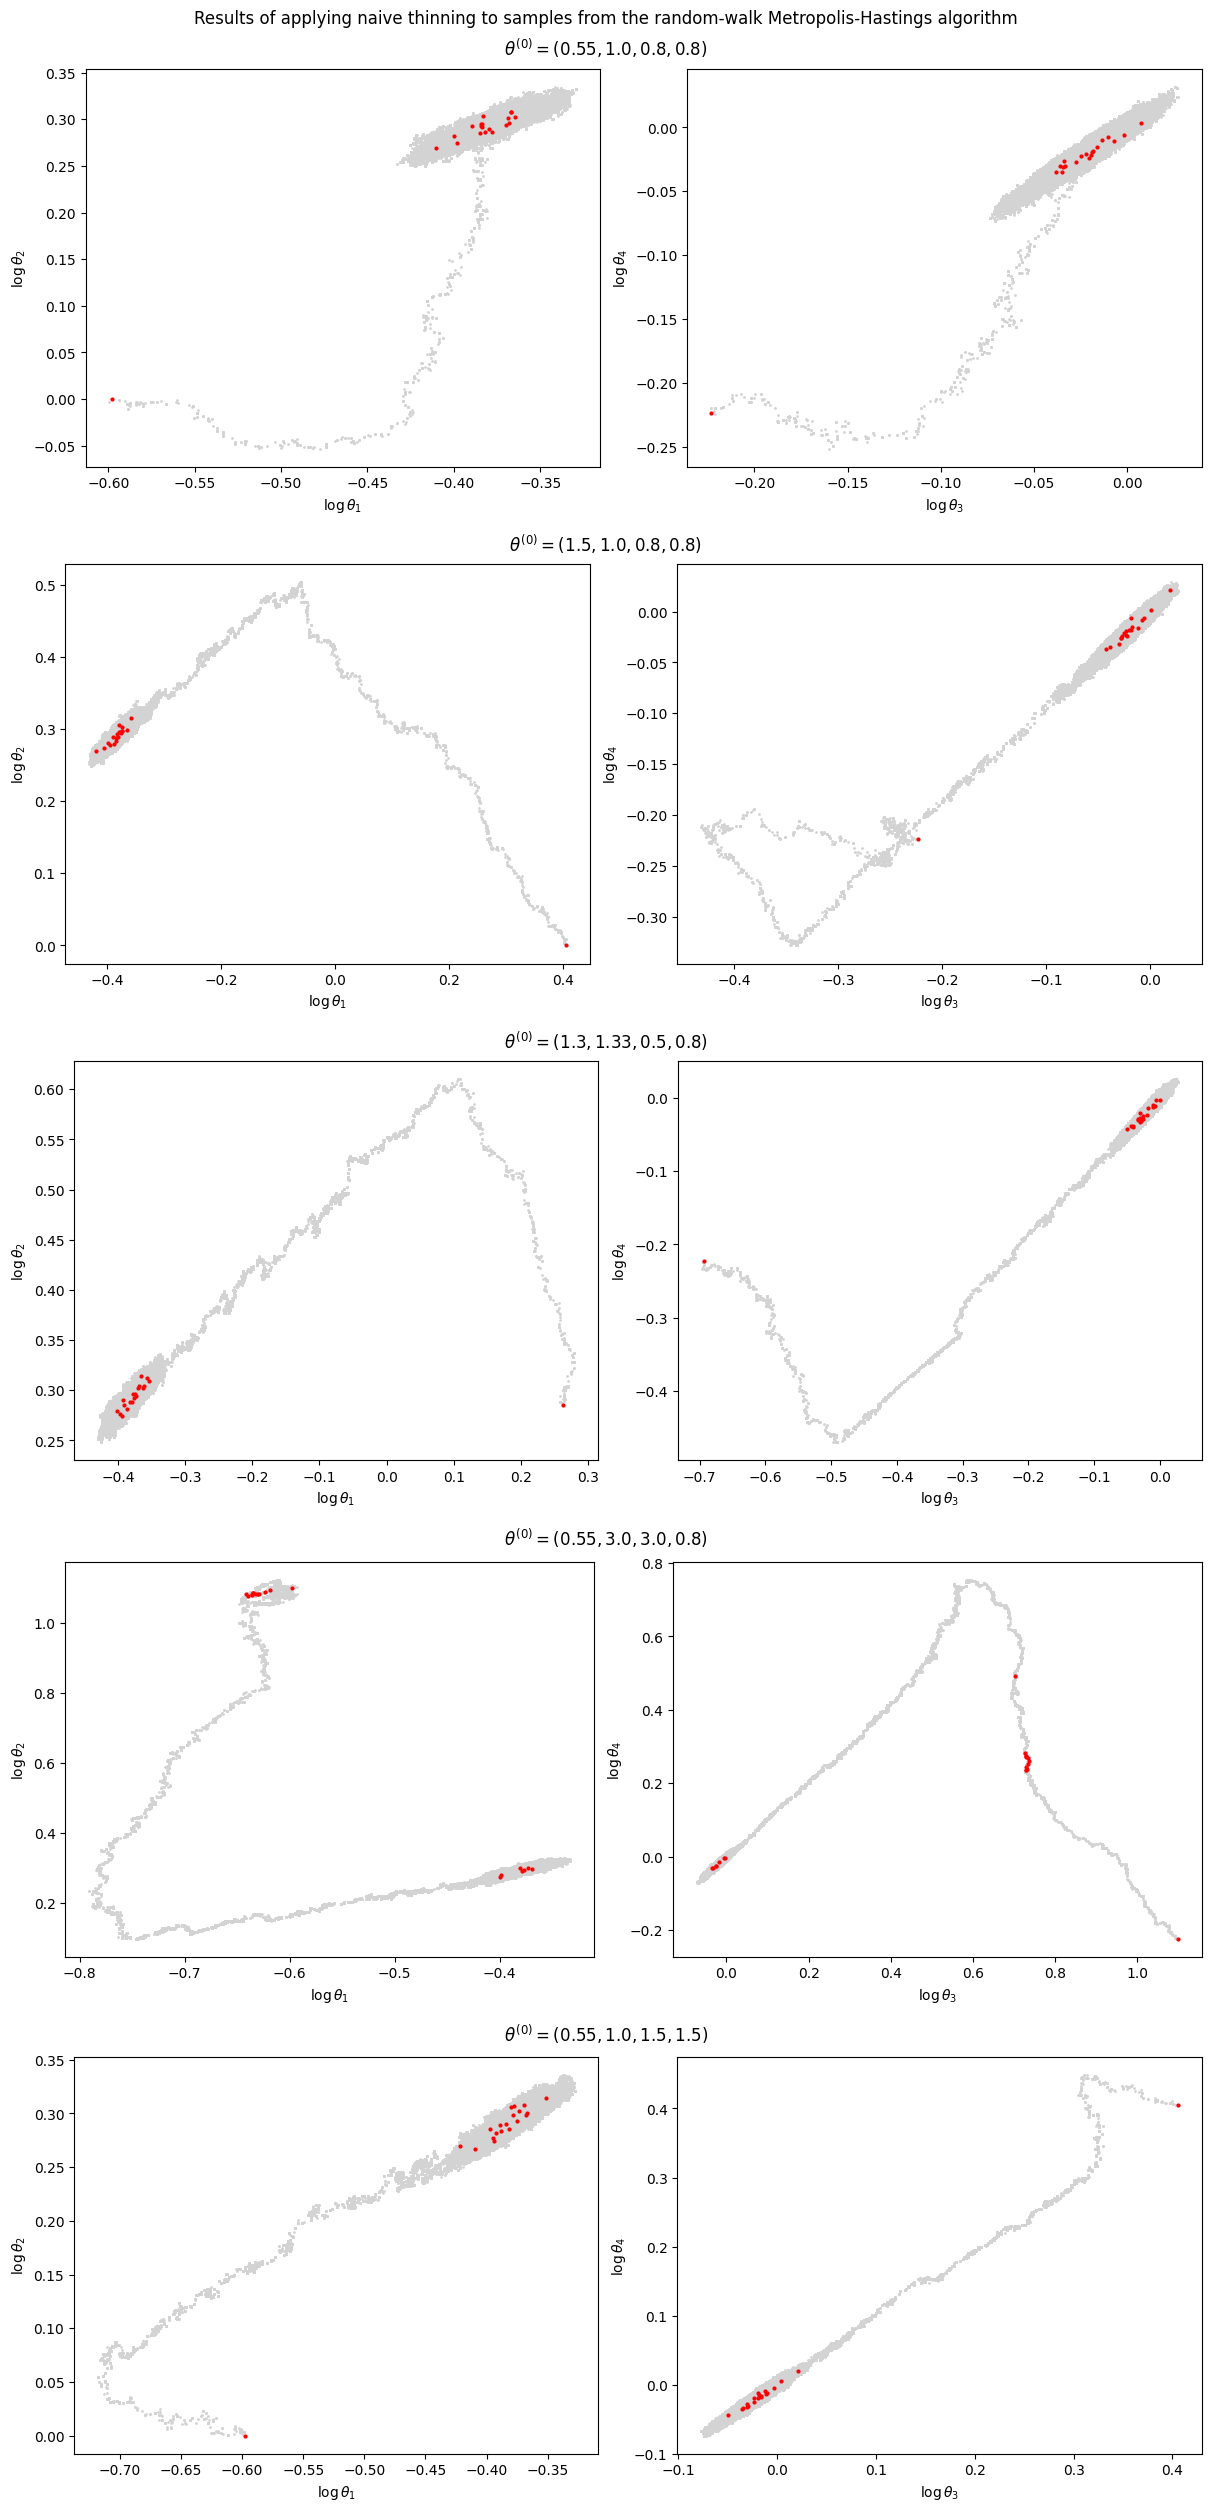

In [81]:
fig = plot_sample_thinned(rw_samples, rw_naive_idx, titles, var_labels);
fig.savefig(figures_path / 'lotka-volterra-naive-thinning.png', dpi=300);
fig.suptitle('Results of applying naive thinning to samples from the random-walk Metropolis-Hastings algorithm');

# Gradient-free Stein thinning

We recalculate the (unnormalised) log target density for all samples. Note that in principle we could have stored it during the MCMC run rather than recalculating it.

In [82]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, rw_samples[i])

In [83]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def hmc_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, hmc_samples[i])

## Simple Gaussian proxy

A simpler approach is to use a Gaussian multivarite proxy matching the sample mean and covariance:

In [84]:
def simple_gaussian_thin(sample, log_p, thinned_size):
    sample_mean = np.mean(sample, axis=0)
    sample_cov = np.cov(sample, rowvar=False, ddof=1)
    log_q = mvn.logpdf(sample, mean=sample_mean, cov=sample_cov)
    gradient_q = -np.einsum('ij,kj->ki', np.linalg.inv(sample_cov), sample - sample_mean)
    return thin_gf(sample, log_p, log_q, gradient_q, n_points_thinned)

In [85]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_simple_gaussian_idx(i: int) -> np.ndarray:
    return simple_gaussian_thin(np.exp(rw_samples[i]), rw_log_p[i], n_points_thinned)

The approach fails to select a representative sample in this case:

In [86]:
rw_simple_gaussian_idx[0]

DEBUG:utils.caching:Reading from disk cache: rw_simple_gaussian_idx_0
DEBUG:utils.caching:Reading ../data/generated/rw_simple_gaussian_idx_0.npy


array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
      dtype=uint32)

The integrand in the gradient-free Stein discrepancy calculation is given by:
$$ \frac{q(x)}{p(x)} \frac{q(y)}{p(y)} \left( -4 \beta(\beta-1) \frac{\| \Gamma^{-1}(x - y)\|^2}{(c^2 + \|\Gamma^{-1/2} (x - y)\|^2)^{-\beta+2}}
- 2 \beta \frac{\text{trace}(\Gamma^{-1}) + \langle \Gamma^{-1} (x - y), \nabla_x \log q(x) - \nabla_y \log q(y)\rangle}{(c^2 + \|\Gamma^{-1/2} (x - y)\|^2)^{-\beta+1}}
+ \frac{\langle \nabla_x \log q(x), \nabla_y \log q(y) \rangle}{(c^2 + \|\Gamma^{-1/2} (x - y)\|^2)^{-\beta}} \right)$$

The coefficient $\frac{q(x)}{p(x)}$ can result in numerical overflow if the orders of magnitude of $q(x)$ and $p(x)$ differ considerably for some points, exceeding the range of exponents that can be represented as floating-point numbers in `numpy`:

In [87]:
(np.finfo('float64').maxexp - np.finfo('float64').minexp) * np.log(2)

1418.1791314256482

We plot the values of $\log q(x) - \log p(x)$ calculated for the sample points for the first random-walk chain:

DEBUG:utils.caching:Reading from disk cache: rw_log_p_0
DEBUG:utils.caching:Reading ../data/generated/rw_log_p_0.npy


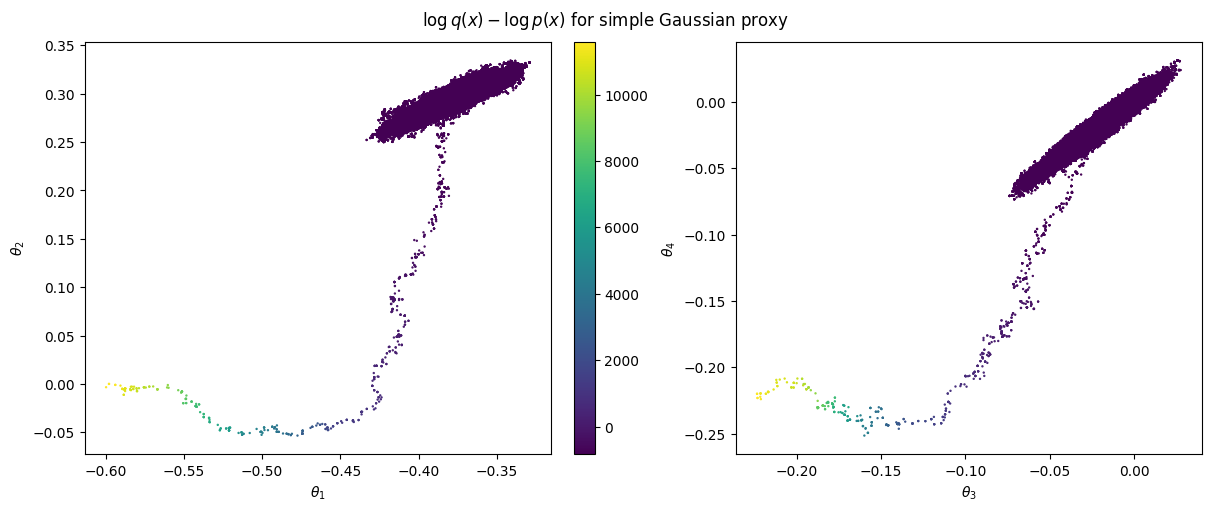

In [88]:
sample_mean = np.mean(rw_samples[0], axis=0)
sample_cov = np.cov(rw_samples[0], rowvar=False, ddof=1)
log_q = mvn.logpdf(rw_samples[0], mean=sample_mean, cov=sample_cov)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 5))
fig.suptitle('$\\log q(x) - \\log p(x)$ for simple Gaussian proxy');
sc = axs[0].scatter(rw_samples[0][:, 0], rw_samples[0][:, 1], s=0.5, c=log_q - rw_log_p[0]);
axs[0].set_xlabel('$\\theta_1$');
axs[0].set_ylabel('$\\theta_2$');
axs[1].scatter(rw_samples[0][:, 2], rw_samples[0][:, 3], s=0.5, c=log_q - rw_log_p[0]);
axs[1].set_xlabel('$\\theta_3$');
axs[1].set_ylabel('$\\theta_4$');
fig.colorbar(sc);

We can see that the range of $\log q(x) - \log p(x)$ exceeds what is representable:

In [89]:
np.max(log_q - rw_log_p[0])

11592.47071750847

In [90]:
np.min(log_q - rw_log_p[0])

-836.4751765372264

The thinning procedure selects points that minimise the total discrency, so points with very large coefficient $\frac{q(x)}{p(x)}$ are unlikely to be selected. We can therefore attempt to cap the values of $\log q(x) - \log p(x)$ to make sure values fit into the representable range.

In [91]:
def gaussian_range_cap_thin(sample, log_p, thinned_size, range_cap):
    sample_mean = np.mean(sample, axis=0)
    sample_cov = np.cov(sample, rowvar=False, ddof=1)
    log_q = mvn.logpdf(sample, mean=sample_mean, cov=sample_cov)
    gradient_q = -np.einsum('ij,kj->ki', np.linalg.inv(sample_cov), sample - sample_mean)
    return thin_gf(sample, log_p, log_q, gradient_q, n_points_thinned, range_cap=range_cap)

In [92]:
range_cap = 300

In [93]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_gf_gaussian_cap_idx(i: int) -> np.ndarray:
    return gaussian_range_cap_thin(rw_samples[i], rw_log_p[i], n_points_thinned, range_cap=range_cap)

DEBUG:utils.caching:Reading from disk cache: rw_gf_gaussian_cap_idx_0
DEBUG:utils.caching:Reading ../data/generated/rw_gf_gaussian_cap_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_gf_gaussian_cap_idx_1
DEBUG:utils.caching:Reading ../data/generated/rw_gf_gaussian_cap_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_gf_gaussian_cap_idx_2
DEBUG:utils.caching:Reading ../data/generated/rw_gf_gaussian_cap_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_gf_gaussian_cap_idx_3
DEBUG:utils.caching:Reading ../data/generated/rw_gf_gaussian_cap_idx_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_gf_gaussian_cap_idx_4
DEBUG:utils.caching:Reading ../data/generated/rw_gf_gaussian_cap_idx_4.npy


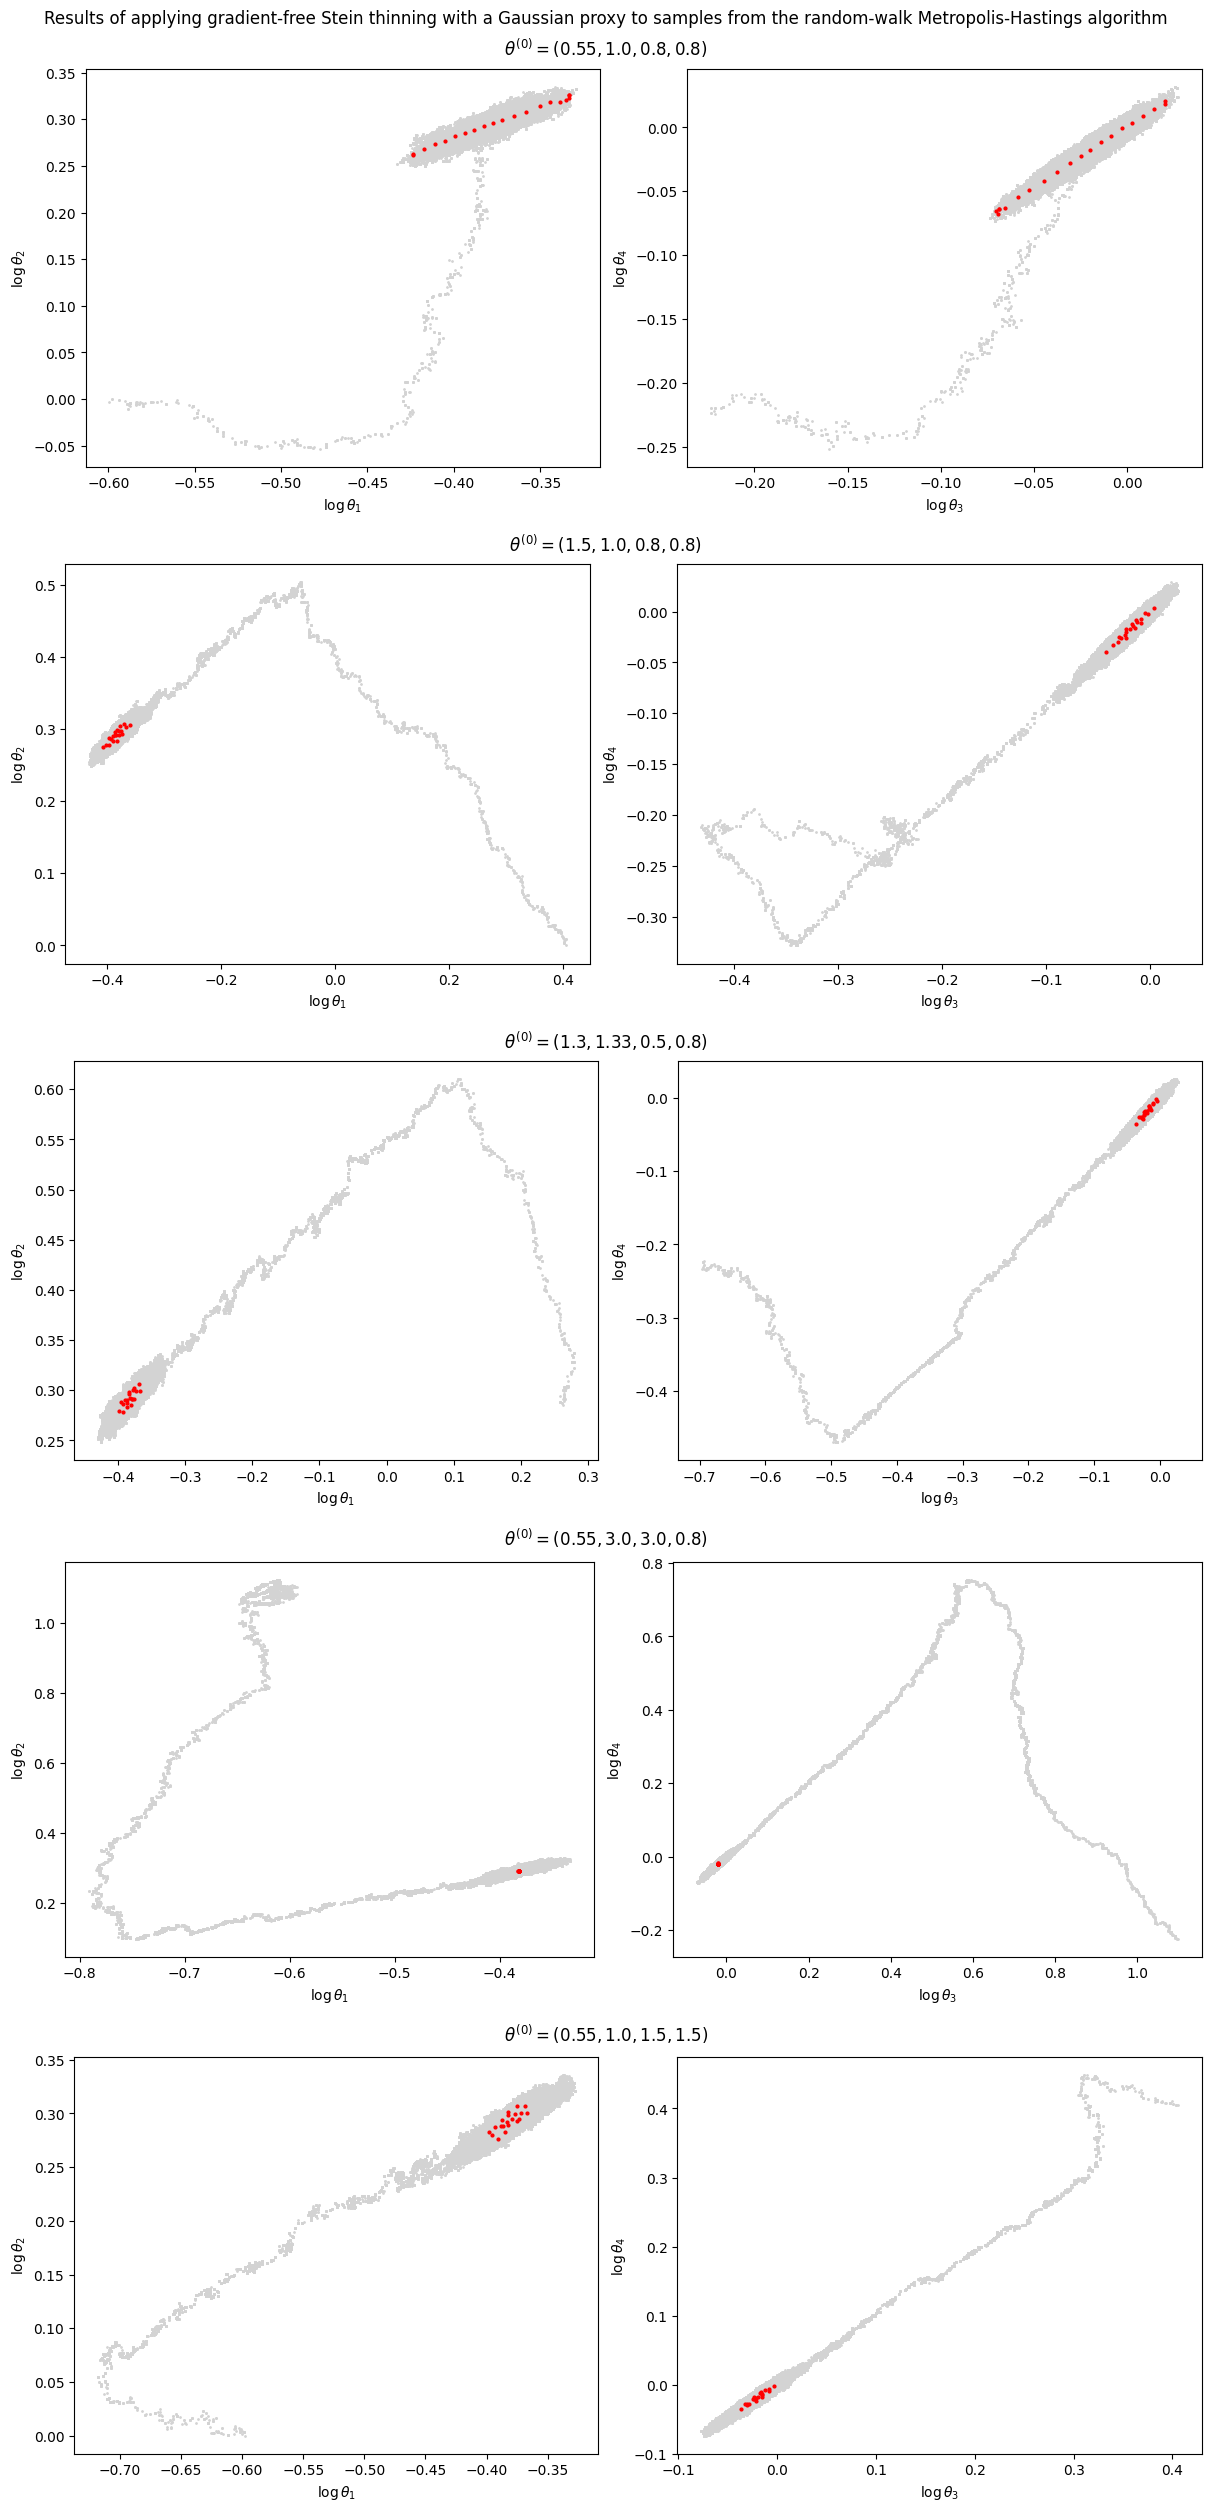

In [94]:
fig = plot_sample_thinned(rw_samples, rw_gf_gaussian_cap_idx, titles, var_labels);
fig.suptitle('Results of applying gradient-free Stein thinning with a Gaussian proxy to samples from the random-walk Metropolis-Hastings algorithm');

## Manual proxy selection

An alternative approach is to try to come up with a proxy that approximates the tails of the target distribution.

We plot $\log p(x) - \max \log p(x)$ versus the Euclidean distance from the point attaining the maximum probability and attempt to find a function that provides a reasonable fit:

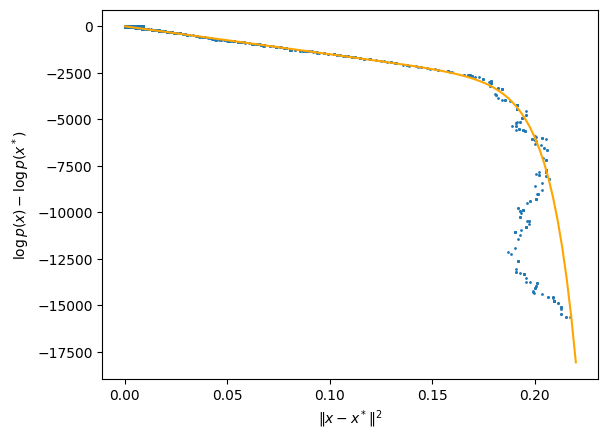

In [95]:
i = 0
sample = rw_samples[i]
sample_mean = np.mean(sample, axis=0)
ref_idx = np.argmax(rw_log_p[i])
dists = cdist(sample[ref_idx].reshape(1, -1), sample).squeeze()
prob_diff = rw_log_p[i] - rw_log_p[i][ref_idx]

a = 15000
b = 80
c = 0.10
def log_q_approx(x):
    return -a * x - np.exp(b * (x - c))

fig, ax = plt.subplots()
ax.scatter(dists ** 2, prob_diff, s=1);

x = np.linspace(0, 0.22, 100)
ax.plot(x, log_q_approx(x), color='orange');

ax.set_xlabel('$\\|x - x^* \\|^2$');
ax.set_ylabel('$\\log p(x) - \\log p(x^*)$');

We use the function and its gradient as the proxies for gradient-free thinning:

In [96]:
log_q = log_q_approx(dists)
gradient_q = -2 * a * (sample - sample[ref_idx]) - 2 * np.exp(b * dists.reshape(-1, 1) - c) * (sample - sample[ref_idx])

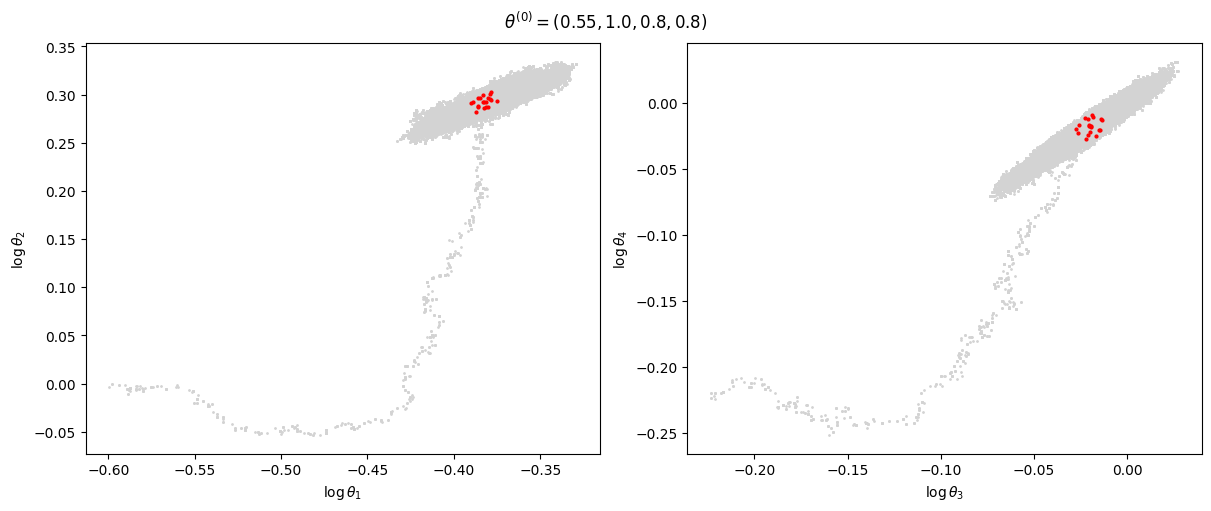

In [97]:
idx = thin_gf(sample, rw_log_p[0], log_q, gradient_q, n_points_thinned, range_cap=20)
fig = plot_sample_thinned([rw_samples[0]], [idx], titles, var_labels);

We calculate the energy distance between thinned samples and the validation sample:

In [98]:
def fit_quality(subsample):
    return np.sqrt(dcor.energy_distance(validation_sample[::10], subsample))

This subsample achieves a fit on par with importance resampling and better than standard Stein thinning:

In [99]:
fit_quality(sample[idx])

0.06474128388239155

## Gaussian mixture proxy

In [100]:
n_mixture_components = 100

In [101]:
idx = np.linspace(0, rw_samples[0].shape[0] - 1, n_mixture_components).astype(int)

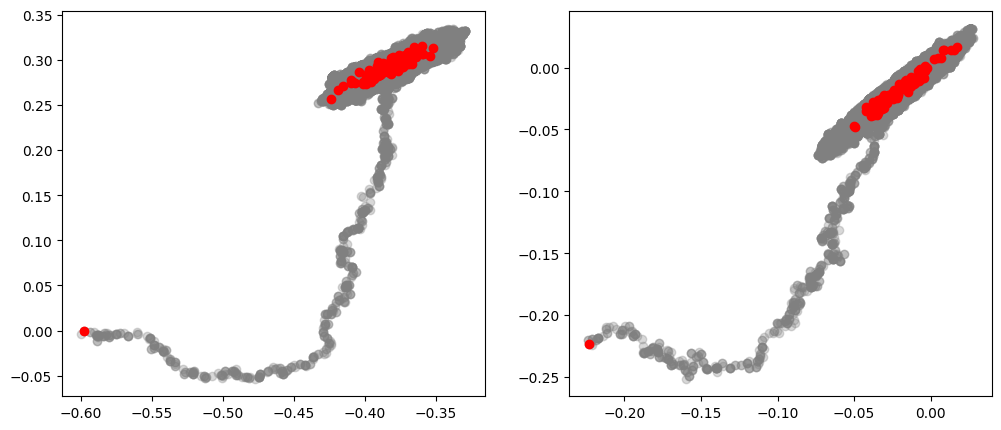

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
highlight_points(rw_samples[0][:, :2], idx, ax=axs[0]);
highlight_points(rw_samples[0][:, 2:], idx, ax=axs[1]);

In [103]:
sample_mean = np.mean(rw_samples[0], axis=0)
sample_cov = np.cov(rw_samples[0], rowvar=False, ddof=1)

In [104]:
rvs, logpdf, score, logpdf_jax = make_mvn_mixture(
    np.ones(len(idx)) / len(idx),
    rw_samples[0][idx, :],
    np.repeat(sample_cov[np.newaxis, :, :], len(idx), axis=0),
)

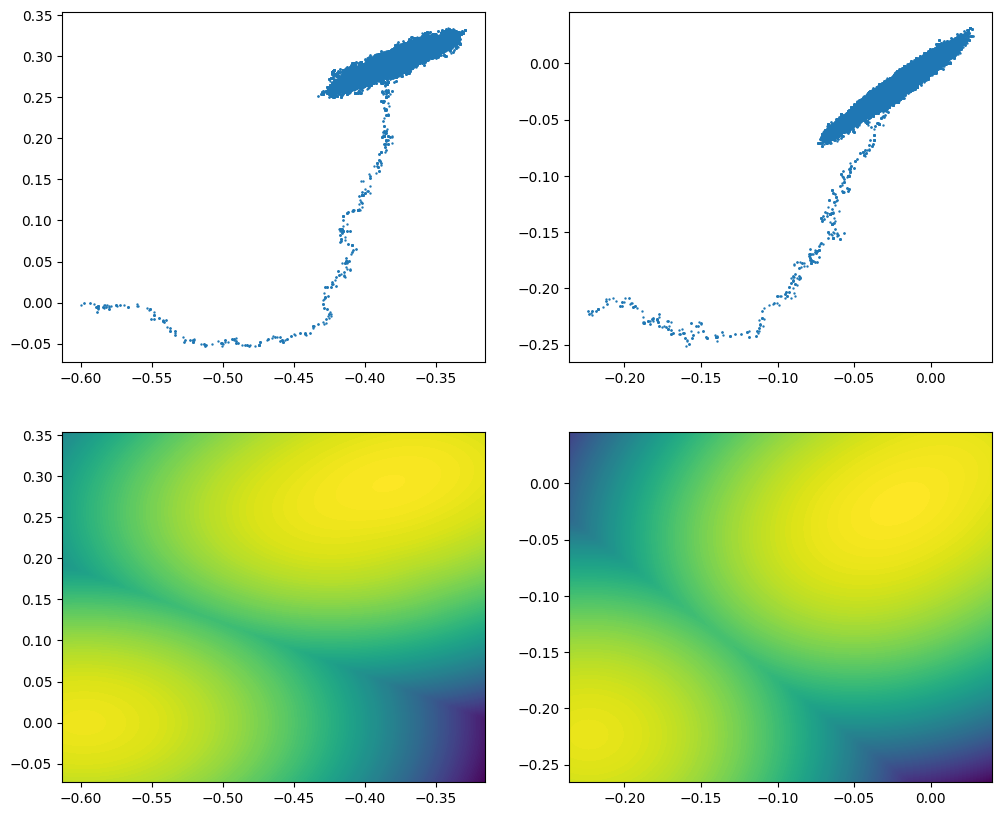

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0][0].scatter(rw_samples[0][:, 0], rw_samples[0][:, 1], s=0.5);
axs[0][1].scatter(rw_samples[0][:, 2], rw_samples[0][:, 3], s=0.5);
plot_density(lambda x: logpdf(x, axes=[0, 1]), axs[1][0], axs[0][0].get_xlim(), axs[0][0].get_ylim(), '');
plot_density(lambda x: logpdf(x, axes=[2, 3]), axs[1][1], axs[0][1].get_xlim(), axs[0][1].get_ylim(), '');

In [106]:
def make_gmm_proxy(sample, idx):
    sample_mean = np.mean(sample, axis=0)
    sample_cov = np.cov(sample, rowvar=False, ddof=1)
    return make_mvn_mixture(
        np.ones(len(idx)) / len(idx),
        sample[idx, :],
        np.repeat(sample_cov[np.newaxis, :, :], len(idx), axis=0),
    )

In [107]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_gmm_log_q(i: int) -> np.ndarray:
    sample = rw_samples[i]
    idx = np.linspace(0, sample.shape[0] - 1, n_mixture_components).astype(int)
    rvs, logpdf, score, logpdf_jax = make_gmm_proxy(sample, idx)
    return logpdf(sample)

@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_gmm_gradient_q(i: int) -> np.ndarray:
    sample = rw_samples[i]
    idx = np.linspace(0, sample.shape[0] - 1, n_mixture_components).astype(int)
    rvs, logpdf, score, logpdf_jax = make_gmm_proxy(sample, idx)
    return score(sample)

DEBUG:utils.caching:Reading from disk cache: rw_gmm_log_q_0
DEBUG:utils.caching:Reading ../data/generated/rw_gmm_log_q_0.npy


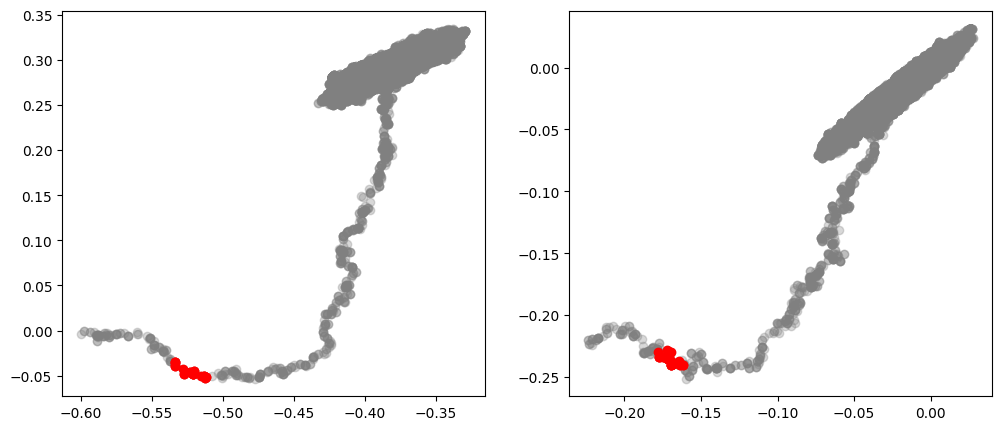

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
highlight_points(rw_samples[0][:, :2], np.argwhere(np.isinf(rw_gmm_log_q[0])), ax=axs[0]);
highlight_points(rw_samples[0][:, 2:], np.argwhere(np.isinf(rw_gmm_log_q[0])), ax=axs[1]);

In [109]:
idx = [0, 100, 200, 300, 500, 2000]

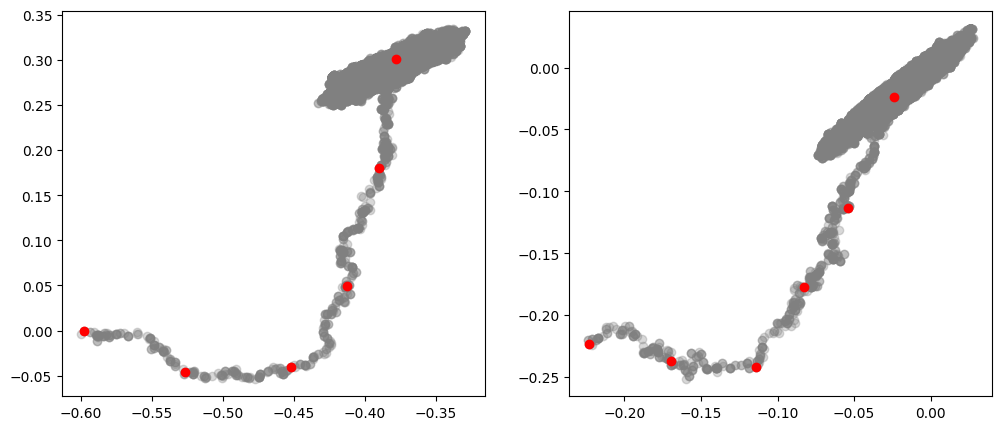

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
highlight_points(rw_samples[0][:, :2], idx, ax=axs[0]);
highlight_points(rw_samples[0][:, 2:], idx, ax=axs[1]);

In [111]:
rvs, logpdf, score, logpdf_jax = make_mvn_mixture(
    np.ones(len(idx)) / len(idx),
    rw_samples[0][idx, :],
    np.repeat(sample_cov[np.newaxis, :, :], len(idx), axis=0),
)

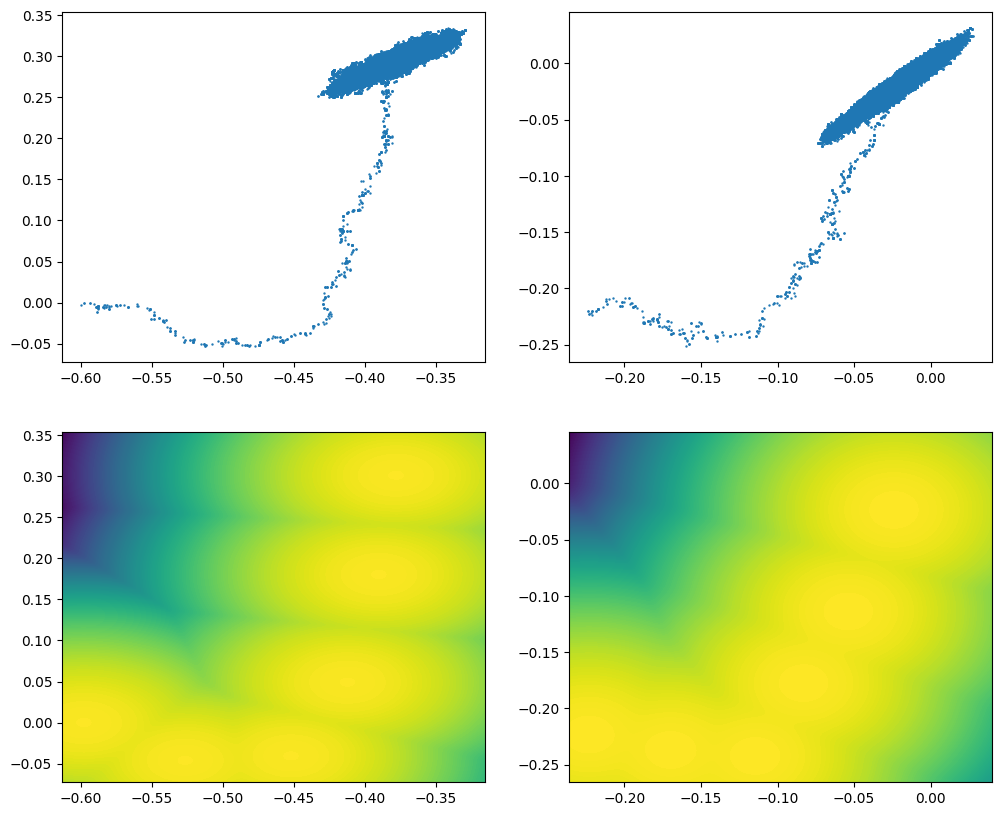

In [112]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0][0].scatter(rw_samples[0][:, 0], rw_samples[0][:, 1], s=0.5);
axs[0][1].scatter(rw_samples[0][:, 2], rw_samples[0][:, 3], s=0.5);
plot_density(lambda x: logpdf(x, axes=[0, 1]), axs[1][0], axs[0][0].get_xlim(), axs[0][0].get_ylim(), '');
plot_density(lambda x: logpdf(x, axes=[2, 3]), axs[1][1], axs[0][1].get_xlim(), axs[0][1].get_ylim(), '');

In [113]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_gmm_manual_log_q(i: int) -> np.ndarray:
    sample = rw_samples[i]
    rvs, logpdf, score, logpdf_jax = make_gmm_proxy(sample, idx)
    return logpdf(sample)

@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_gmm_manual_gradient_q(i: int) -> np.ndarray:
    sample = rw_samples[i]
    rvs, logpdf, score, logpdf_jax = make_gmm_proxy(sample, idx)
    return score(sample)

In [114]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_gf_gmm_idx(i: int) -> np.ndarray:
    return thin_gf(
        rw_samples[i],
        rw_log_p[i],
        rw_gmm_manual_log_q[i],
        rw_gmm_manual_gradient_q[i],
        n_points_thinned,
    )

In [115]:
rw_gf_gmm_idx[0]

DEBUG:utils.caching:Reading from disk cache: rw_gf_gmm_idx_0
DEBUG:utils.caching:Reading ../data/generated/rw_gf_gmm_idx_0.npy


array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
      dtype=uint32)

## KDE proxy

The default implementation of KDE places the kernel at every sample points. The density then needs to be estimated at every sample point, thus leading to $O(n^2)$ computational cost. For large $n$, this becomes prohibitive, so we use a fixed number of points in the density estimate.

In [116]:
def thin_gf_kde(sample, log_p, thinned_size, n_points_kde=100):
    idx = np.linspace(0, sample.shape[0] - 1, n_points_kde).astype(int)
    kde = jgaussian_kde(sample[idx, :].T, bw_method='silverman')
    log_q = np.array(kde.logpdf(sample.T))
    kde_grad = grad(lambda x: kde.logpdf(x)[0])
    gradient_q = np.array(jnp.apply_along_axis(kde_grad, 1, sample))
    return thin_gf(sample, log_p, log_q, gradient_q, thinned_size)

In [117]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_gf_kde_idx(i: int) -> np.ndarray:
    return thin_gf_kde(rw_samples[i], rw_log_p[i], n_points_thinned)

We can see that the approach fails to select a representative subsample in this case:

DEBUG:utils.caching:Reading from disk cache: rw_gf_kde_idx_0
DEBUG:utils.caching:Reading ../data/generated/rw_gf_kde_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_gf_kde_idx_1
DEBUG:utils.caching:Reading ../data/generated/rw_gf_kde_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_gf_kde_idx_2
DEBUG:utils.caching:Reading ../data/generated/rw_gf_kde_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_gf_kde_idx_3
DEBUG:utils.caching:Reading ../data/generated/rw_gf_kde_idx_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_gf_kde_idx_4
DEBUG:utils.caching:Reading ../data/generated/rw_gf_kde_idx_4.npy


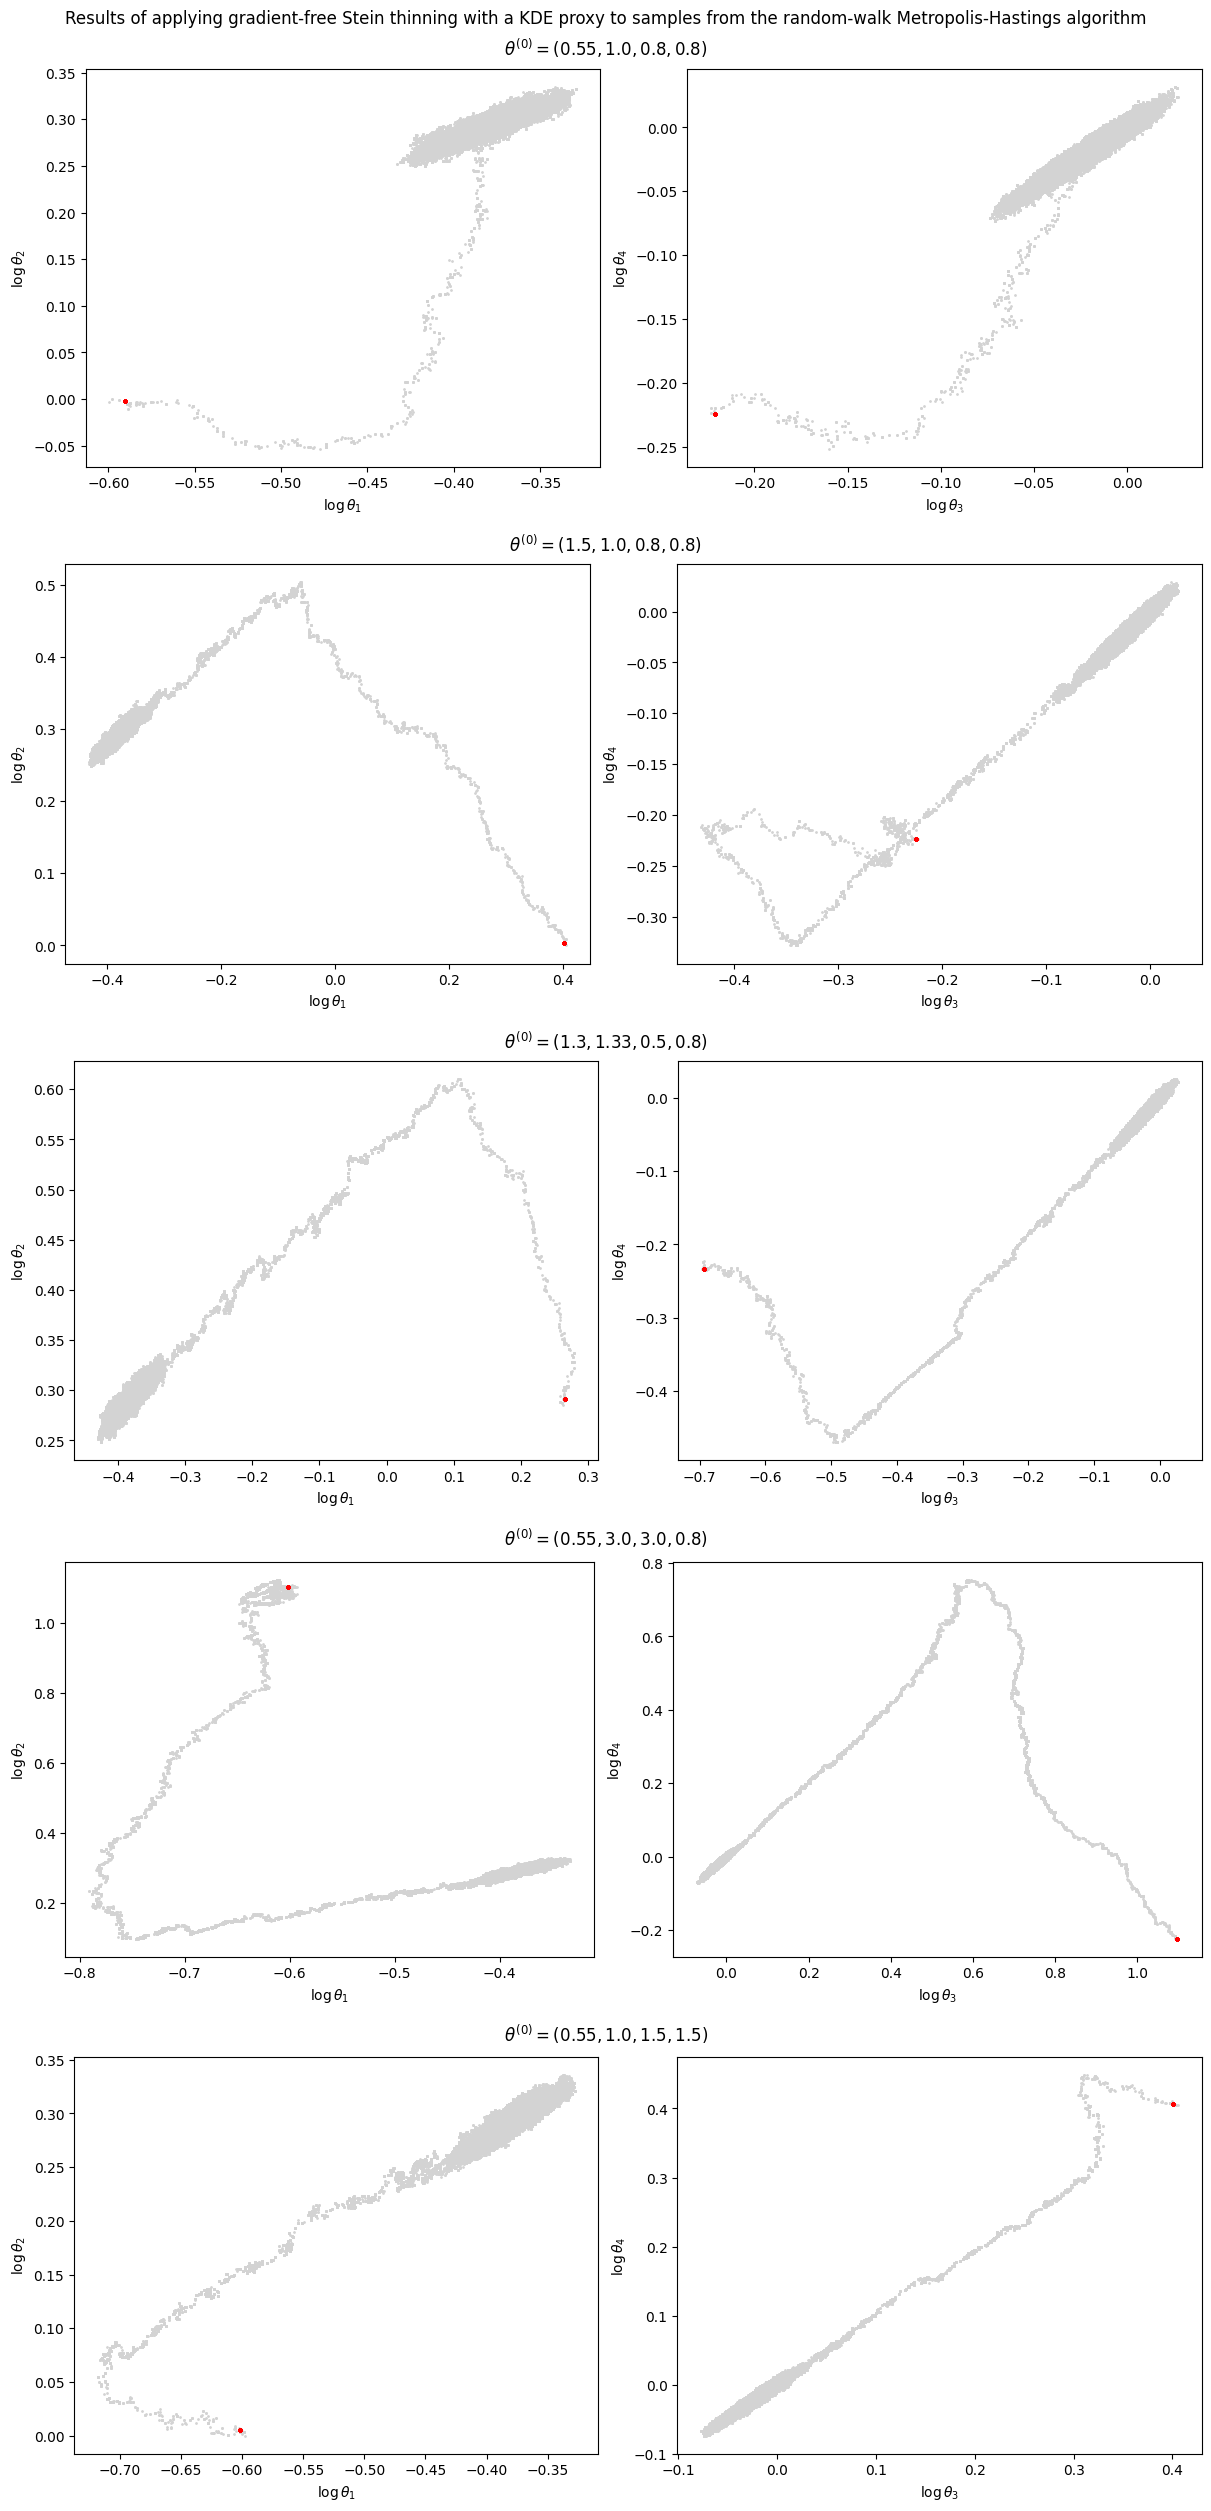

In [118]:
fig = plot_sample_thinned(rw_samples, rw_gf_kde_idx, titles, var_labels);
fig.suptitle('Results of applying gradient-free Stein thinning with a KDE proxy to samples from the random-walk Metropolis-Hastings algorithm');

# Energy distance comparison

In [119]:
comparison_entries = {
    'Stein thinning': rw_thinned_idx,
    'Naive thinning': rw_naive_idx,
    'Gradient-free Stein thinning with Gaussian proxy and range cap': rw_gf_gaussian_cap_idx,
}

In [120]:
def create_fit_table(samples, entries, column_names):
    return pd.DataFrame(
        [[fit_quality(samples[i][indices[i]]) for i in range(len(samples))] for _, indices in entries.items()],
        index=entries.keys(),
        columns=column_names,
    )

In [121]:
@cached(recalculate=recalculate, persist=True)
def rw_energy_distance_table() -> pd.DataFrame:
    return create_fit_table(rw_samples, comparison_entries, range(1, len(rw_samples) + 1))

In [122]:
%%time
rw_energy_distance_table()

DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_table
DEBUG:utils.caching:Reading ../data/generated/rw_energy_distance_table


CPU times: user 3.21 ms, sys: 541 μs, total: 3.75 ms
Wall time: 3.42 ms


,1,2,3,4,5
Stein thinning,0.111670,0.119363,0.106322,0.083446,0.119749
Naive thinning,0.104455,0.111979,0.134359,0.969531,0.122932
Gradient-free Stein thinning with Gaussian proxy and range cap,0.177120,0.087494,0.077597,0.087323,0.074433


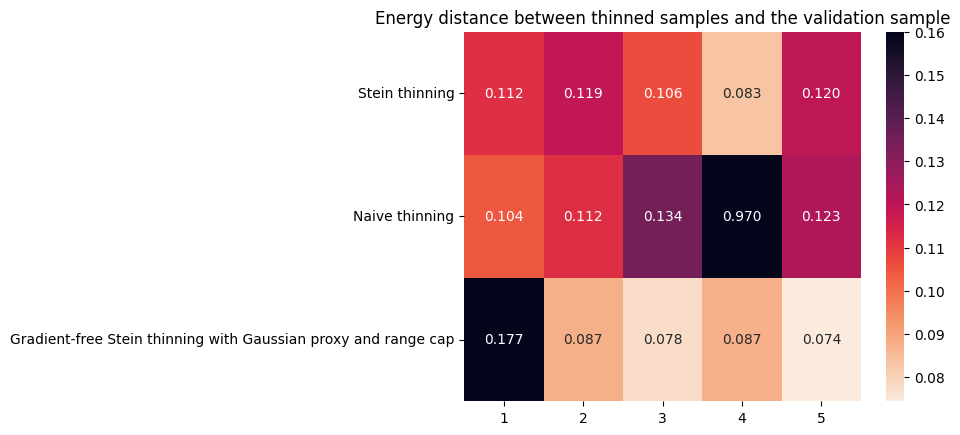

In [123]:
ax = sns.heatmap(
    rw_energy_distance_table(),
    annot=True,
    fmt='.3f',
    cmap=sns.cm.rocket_r,
    vmax=np.quantile(rw_energy_distance_table(), 0.9)
);
ax.set_title('Energy distance between thinned samples and the validation sample');

Notebook execution took:

In [124]:
time.time() - start_time

393.99144315719604